# Load Indenpenciesiseaus

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
!git clone https://github.com/AfterRain007/Skripsi
!ls
!pip install transformers -q
!pip install sentencepiece -q
import time
import shutil
# from google.colab import drive
# drive.mount('/content/drive')

Cloning into 'Skripsi'...
remote: Enumerating objects: 1991, done.
remote: Counting objects: 100% (898/898), done.
remote: Compressing objects: 100% (472/472), done.
remote: Total 1991 (delta 430), reused 884 (delta 420), pack-reused 1093
Receiving objects: 100% (1991/1991), 302.73 MiB | 21.49 MiB/s, done.
Resolving deltas: 100% (854/854), done.
Updating files: 100% (906/906), done.
sample_data  Skripsi


# Data Preparation

## Manually Labelled Data

In [ ]:
DIR = "Skripsi/Trash/Manual/"

In [ ]:
df = pd.read_csv(DIR + "manualLabelled.csv", usecols=['text', 'sen'])
df2 = pd.read_csv(DIR + "negSenVerified.csv", usecols=['text', 'sen'])
df3 = pd.read_csv(DIR + "negSenVerified2.csv", usecols=['text', 'sen'])
df4 = pd.read_csv(DIR + "negSenVerified3.csv", usecols=['text', 'sen'])
df5 = pd.read_csv(DIR + "negSenVerified4.csv", usecols=['text', 'sen'])
df6 = pd.read_csv(DIR+"Crypto Sentiment Dataset.csv", usecols=['Comment Text', 'Sentiment'])
df7 = pd.read_csv(DIR+"spreadsheetNegVer.csv", usecols=['text', 'sen'])

In [ ]:
df2 = df2.loc[df2['sen'] == 1].assign(sen=-1)
df3 = df3.loc[df3['sen'] == 1].assign(sen=-1)
df4 = df4.loc[df4['sen'] == 1].assign(sen=-1)
df5 = df5.loc[df5['sen'] == 1].assign(sen=-1)

In [ ]:
sentiment_mapping = {'Negative': -1, 'Neutral': 0, 'Positive': 1}
df6['Sentiment'] = df6['Sentiment'].map(sentiment_mapping)
df6 = df6.rename(columns={"Comment Text":"text", 'Sentiment':'sen'})

In [ ]:
df = pd.concat([df, df2, df3, df4, df5, df6, df7])

In [ ]:
df = df[df['sen']<2]
df.reset_index(inplace = True, drop = True)
print(f"Final amount of Fine Tune data: {len(df)}")
df['sen'].value_counts()

Final amount of Fine Tune data: 3420


 0    1371
 1    1332
-1     717
Name: sen, dtype: int64

### Cleaning

In [ ]:
#Import all the module
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import torch
from html import unescape

#Delete """" if you haven't download

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

#Delete """" if you haven't download

# Compile the regular expressions outside the clean_text function
url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
ftp_pattern = re.compile(r'ftp[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

# Set of punctuation characters
punctuation_set = set(string.punctuation)

def clean_text(text):
    t = re.sub(url_pattern, ' ', text)  # remove urls if any
    t = re.sub(ftp_pattern, ' ', t)  # remove urls if any
    t = unescape(t)  # html entities fix

    # Convert text to lowercase
    text = t.lower()

    # Remove punctuation
    text = ''.join(char for char in text if char not in punctuation_set)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove special characters and numbers
    tokens = [re.sub(r"[^a-zA-Z]", "", token) for token in tokens]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove unnecessary spaces
    tokens = [token.strip() for token in tokens if token.strip()]

    # Join tokens back into a single string
    cleaned_text = " ".join(tokens)

    return cleaned_text

# Example usage
text = "This is an example sentence! 123# https://www.youtube.com/watch?v=_9bw_VtMUGA"
cleaned_text = clean_text(text)
print(cleaned_text)

df['text'] = df['text'].astype(str)
df['text'] = df['text'].apply(clean_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


example sentence


KeyboardInterrupt: 

In [ ]:
df['WC'] = df['text'].apply(lambda x: len(x.split()))
print(len(df[df['WC']>4]))

In [ ]:
df = df[~((df['WC'] < 4) & ((df['sen'] == 1) | (df['sen'] == 0)))].sort_values(by=['WC'])

In [ ]:
len(df)

In [ ]:
df = df[~((df['text'].str.contains('bitcoin going', flags=re.IGNORECASE)) &
      ~(df['text'].str.contains('bitcoin okay bro', flags=re.IGNORECASE)) &
      ~(df['text'].str.contains('explode', flags=re.IGNORECASE)) &
      ~(df['text'].str.contains('know going', flags=re.IGNORECASE)) &
      ~(df['text'].str.contains('bitcoin k loading', flags=re.IGNORECASE)) &
      ~(df['text'].str.contains('full audit usdc', flags=re.IGNORECASE)) &
      ~(df['text'].str.contains('record didnt need', flags=re.IGNORECASE)) &
      ~(df['text'].str.contains('squawkcnbc jerrymoran bitcoin', flags=re.IGNORECASE)) &
      ((df['sen'] != -1) | (df['WC'] > 4)))]

In [ ]:
df.reset_index(inplace = True, drop = True)

In [ ]:
del dfTrain['WC']
del dfTest['WC']
del dfVal['WC']

### Partitioninigninnigg

In [ ]:
# Create a new DataFrame with 250 rows of each label
sample_size = 200

dfM1 = df[df['sen'] == -1].head(sample_size)
df0 = df[df['sen'] == 0].head(sample_size)
df1 = df[df['sen'] == 1].head(sample_size)

dfVT = pd.concat([dfM1, df0, df1])

In [ ]:
indices_to_remove = dfVT.index

In [ ]:
sample_size = 100
dfM1 = dfVT[dfVT['sen'] == -1].head(sample_size)
df0 = dfVT[dfVT['sen'] == 0].head(sample_size)
df1 = dfVT[dfVT['sen'] == 1].head(sample_size)

dfVal = pd.concat([dfM1, df0, df1])

dfM1 = dfVT[dfVT['sen'] == -1].tail(sample_size)
df0 = dfVT[dfVT['sen'] == 0].tail(sample_size)
df1 = dfVT[dfVT['sen'] == 1].tail(sample_size)

dfTest = pd.concat([dfM1, df0, df1])

In [ ]:
dfTrain = df.drop(indices_to_remove)
dfTrain.reset_index(inplace = True, drop = True)
dfVal.reset_index(inplace = True, drop = True)
dfTest.reset_index(inplace = True, drop = True)

In [ ]:
dfTrain.to_csv("dfTrain.csv", index = False)
dfVal.to_csv("dfVal.csv", index = False)
dfTest.to_csv("dfTest.csv", index = False)

In [ ]:
print(f"Banyak data train: {len(dfTrain)}")
print(f"Banyak data validation: {len(dfVal)}")
print(f"Banyak data test: {len(dfTest)}")

## Sentiment Labelling

### Loading Raw Data

In [ ]:
!pip install opendatasets -q
!pip install kaggle -q

In [ ]:
import opendatasets as od
import json

! cp ./Skripsi/kaggle.json ./
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat './Skripsi/kaggle.json': No such file or directory
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# Download datasets using opendatasets
od.download("https://www.kaggle.com/datasets/kaushiksuresh147/bitcoin-tweets")
od.download("https://www.kaggle.com/datasets/afterrain007/reddit-bitcoin-topic-text")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

Abort: 

### Cleaning

In [ ]:
import gc

In [ ]:
# reading the CSV file
df = pd.read_csv('./bitcoin-tweets/Bitcoin_tweets.csv', usecols = ['date', 'text'], dtype = {"date": str, "text" : str})
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.dropna(inplace = True)
gc.collect()
df.head()

In [ ]:
dfReddit = pd.read_csv('./reddit-bitcoin-topic-text/redditText.csv', usecols = ['timestamp', 'comments'])
dfReddit.rename(columns={'comments': 'text', 'timestamp' : 'date'}, inplace=True)
dfReddit['date'] = pd.to_datetime(dfReddit['date'], unit='s', errors='coerce')
dfReddit = dfReddit[dfReddit['text'] != '[deleted]']
dfReddit.dropna(inplace = True)

gc.collect()

In [ ]:
df = pd.concat([df, dfReddit])
df.set_index('date', inplace=True)
print(len(df))

In [ ]:
df = df.sort_index()

In [ ]:
# df['text'] = df['text'].astype(str)
# #Spam Tweet Example

# dfSpam1 = df[df['text'].str.contains('Compared to the last tweet, the price has', flags=re.IGNORECASE)].head()
# dfSpam2 = df[df['text'].str.contains('Bitcoin Whale Alert:', flags=re.IGNORECASE)].head()
# dfSpam3 = df[df['text'].str.contains('#bitcoin LONGED', flags=re.IGNORECASE)].head()
# dfSpam4 = df[df['text'].str.contains('Market Cap. Swap', flags=re.IGNORECASE)].head()
# dfSpam5 = df[df['text'].str.contains('Bitcoin BTC Current Price:', flags=re.IGNORECASE)].head()

# dfSpam = pd.concat([dfSpam1[:1],dfSpam2[:1],dfSpam3[:1],dfSpam4[:1],dfSpam5[:1]])
# dfSpam.to_excel("dfSpam.xlsx")
# len(dfSpam)

In [ ]:
print(len(df))

df = df[(~df['text'].str.contains('Compared to the last tweet, the price has', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('In the last 24 hours the price has', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('transferred from Unknown Wallet to Unknown Wallet', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('Market Cap. Swap', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('Bitcoin BTC Current Price:', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('Current #Bitcoin Price is', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('Bitcoin Whale Alert:', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('tx with a value of', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('will be transfered from', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('Someone just transfered', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('is a super underrated bitcoiner I’ve been following', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('has been transfered to an', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('transferred from unknown wallet to', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('Someone just transfered', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('is a super underrated bitcoiner I’ve been following her tweets and tips', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('Market Cap. Swap', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('Bitcoin BTC Current Price:', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('Current #Bitcoin Price is', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('Bitcoin Whale Alert:', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('will be transfered from', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('#bitcoin SHORTED', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('tx with a value of', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('#bitcoin LONGED', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('move from unknown wallet to', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('BTC - short alert', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('1 BTC Price: Bitstamp', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('Trending Crypto Alert!', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('#Bitcoin mempool Tx summary in the last 60 seconds', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('BEARWHALE! just SHORTED', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('Buyer alert:', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('#Bitcoin Price:', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('Based on #coindesk BPI #bitcoin', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('BTCUSDT LONGED', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('Everywhere should follow @', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('BULLWHALE! just LONGED', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('Long Position Taken On $', flags=re.IGNORECASE)) &
        (~df['text'].str.contains("A new block was found on the #Bitcoin network. We're at block height", flags=re.IGNORECASE)) &
        (~df['text'].str.contains('current #bitcoin price is', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('today and watch your life turn around, start earning', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('Symbol: BTCUSD (Binance)', flags=re.IGNORECASE, regex=False)) &
        (~df['text'].str.contains('Current  #Bitcoin Price:', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('transferred from #Coinbase to unknown wallet', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('SCAN RESULTS - 15m - #BTC PAIR', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('$BTC Latest Block Info: Block', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('Scan results - #Gateio - 15m', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('BTCUSD LONGED @', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('Follow for recent Bitcoin price updates.', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('1 BTC Price: Bitstamp', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('The current price of bitcoin is $', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('Symbol:|Signal:|Price:|Volume:', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('Deal Close:|Entry:|Entry Price:', flags=re.IGNORECASE)) &
        (~df['text'].str.contains('Scan results - | - 15m', flags=re.IGNORECASE))]

gc.collect()
print(len(df))

In [ ]:
#Import all the module
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import torch
from html import unescape

#Delete """" if you haven't download

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

#Delete """" if you haven't download

# Compile the regular expressions outside the clean_text function
url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
ftp_pattern = re.compile(r'ftp[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

# Set of punctuation characters
punctuation_set = set(string.punctuation)

def clean_text(text):
    t = re.sub(url_pattern, ' ', text)  # remove urls if any
    t = re.sub(ftp_pattern, ' ', t)  # remove urls if any
    t = unescape(t)  # html entities fix

    # Convert text to lowercase
    text = t.lower()

    # Remove punctuation
    text = ''.join(char for char in text if char not in punctuation_set)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove special characters and numbers
    tokens = [re.sub(r"[^a-zA-Z]", "", token) for token in tokens]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove unnecessary spaces
    tokens = [token.strip() for token in tokens if token.strip()]

    # Join tokens back into a single string
    cleaned_text = " ".join(tokens)

    return cleaned_text

# Example usage
text = "This is an example sentence! 123# https://www.youtube.com/watch?v=_9bw_VtMUGA"
cleaned_text = clean_text(text)
print(cleaned_text)

df['text'] = df['text'].apply(clean_text)

In [ ]:
df['WC'] = df['text'].apply(lambda x: len(x.split()))
df = df[df['WC']>=4]

del df['WC']
gc.collect()
df.head()

In [ ]:
df['time'] = df.index
df.drop_duplicates(inplace = True)
gc.collect()
del df['time']

In [ ]:
df.to_csv("dfText.csv")
shutil.copy(f'dfText.csv', '/content/drive/My Drive/')

### Labelling

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

df = pd.read_csv("/content/drive/My Drive/dfText.csv", usecols = ['date', 'text'])
df['date'] = pd.to_datetime(df['date'],errors='coerce')
df.set_index('date', inplace = True)

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import concurrent
import time as time
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 69420
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

modelName = "AfterRain007/cryptobertRefined"
tokenizer = AutoTokenizer.from_pretrained(modelName)
model = AutoModelForSequenceClassification.from_pretrained(modelName)

model.to(device)
torch.cuda.empty_cache()

def sentiment_score(review):
    # Tokenize the review outside the loop
    tokens = tokenizer(review, return_tensors='pt', max_length = 128, truncation = True).input_ids.to(device)

    # Pass the tokens directly to the model for batch processing
    result = model(tokens)

    # Convert the tensor to a numpy array and extract the predicted sentiment
    sentiment = int(torch.argmax(result.logits)) - 1

    return sentiment

In [ ]:
len(df)

In [ ]:
dfTemp = df[4800000:]
dfTemp['sen'] = dfTemp['text'].apply(sentiment_score)

In [ ]:
dfTemp

In [ ]:
dfTemp.to_csv(f'dfTextSenLast.csv')
shutil.copy(f'dfTextSenLast.csv', "/content/drive/My Drive/")

In [ ]:
from transformers import set_seed
import os
seed = 69420
set_seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

temp = pd.DataFrame()
chunk_size = 100000
skip = 22

for x in np.arange(int(len(df)/chunk_size)):
  if x <= skip:
    continue
  print(f"Starting iteration-{x}")
  dfTemp = df[x*chunk_size:(x+1)*chunk_size]
  dfTemp['sen'] = dfTemp['text'].apply(sentiment_score)
  temp = pd.concat([temp, dfTemp])
  temp.to_csv(f'dfTextSen2_2-{x}.csv')
  shutil.copy(f'dfTextSen2_2-{x}.csv', "/content/drive/My Drive/")
  if os.path.exists(f"/content/drive/My Drive/dfTextSen2_2-{x-1}.csv"):
    os.remove(f"/content/drive/My Drive/dfTextSen2_2-{x-1}.csv")

#EDA

## Loading Data

### Function Pool

In [ ]:
#Import all the module
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import torch
from html import unescape

#Delete """" if you haven't download

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

#Delete """" if you haven't download

# Compile the regular expressions outside the clean_text function
url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
ftp_pattern = re.compile(r'ftp[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

# Set of punctuation characters
punctuation_set = set(string.punctuation)

def clean_text(text):
    t = re.sub(url_pattern, ' ', text)  # remove urls if any
    t = re.sub(ftp_pattern, ' ', t)  # remove urls if any
    t = unescape(t)  # html entities fix

    # Convert text to lowercase
    text = t.lower()

    # Remove punctuation
    text = ''.join(char for char in text if char not in punctuation_set)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove special characters and numbers
    tokens = [re.sub(r"[^a-zA-Z]", "", token) for token in tokens]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove unnecessary spaces
    tokens = [token.strip() for token in tokens if token.strip()]

    # Join tokens back into a single string
    cleaned_text = " ".join(tokens)

    return cleaned_text

# Example usage
text = "This is an example sentence! 123# https://www.youtube.com/watch?v=_9bw_VtMUGA"
cleaned_text = clean_text(text)
print(cleaned_text)

def has_repeating_word(text, repetition_threshold=3):
    # Find all words in the text
    words = re.findall(r'\b\w+\b', text.lower())

    # Create a regular expression pattern for detecting repeating words
    pattern = r'\b(\w+)' + r'(\s+\1){%d,}\b' % (repetition_threshold - 1)

    # Search for the pattern in the text
    match = re.search(pattern, ' '.join(words))

    # Return True if a match is found, indicating repeating words
    return match is not None

def preprocess_dataframe(df, spammy):
  df['text'] = df['text'].astype(str)
  df['text'] = df['text'].apply(clean_text)
  df['WC']   = df['text'].apply(lambda x: len(x.split()))
  df['spam'] = df['text'].apply(has_repeating_word, args=(spammy,))
  df = df[(df['WC'] >= 4) & (df['spam'] == False)].copy()
  df.drop(['WC', 'spam'], axis = 1, inplace = True)
  df = pd.concat([dfTrain, df])
  df.drop_duplicates(subset=['text'], keep=False).reset_index(drop = True, inplace = True)
  return df

def preprocess_dataframe2(df):
  minLen = len(df[df['sen'] == -1])
  df = df[df['sen'].isin([-1, 0, 1])].groupby('sen').head(minLen)
  df.reset_index(inplace = True, drop = True)
  return df

from sklearn.preprocessing import MinMaxScaler
def transform(year, year2=0):
  scaler = MinMaxScaler()
  if year2 == 0:
    temp  = df.loc[year]
    temp1 = scaler.fit_transform(temp)
    temp1 = pd.DataFrame(temp1,columns=temp.columns, index=temp.index)
    return temp1
  temp  = df.loc[year:year2]
  temp1 = scaler.fit_transform(temp)
  temp1 = pd.DataFrame(temp1,columns=temp.columns, index=temp.index)
  return temp1

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


example sentence


### Sen

In [ ]:
!pip install opendatasets -q
!pip install kaggle -q

In [ ]:
import opendatasets as od
import json
import gc

! cp ./Skripsi/Trash/kaggle.json ./
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Download datasets using opendatasets
od.download("https://www.kaggle.com/datasets/afterrain007/bitcoin-tweet-and-reddit-labelled")

100%|██████████| 176M/176M [00:01<00:00, 96.9MB/s]


In [ ]:
from sklearn.preprocessing import MinMaxScaler
# reading the CSV file
dfSen = pd.read_csv('./bitcoin-tweet-and-reddit-labelled/Text.csv', usecols = ['date', 'sen'], dtype = {"date": str,  'sen' : int})
dfSen['date'] = pd.to_datetime(dfSen['date'], errors='coerce')

dfSen['date'] = dfSen['date'].dt.date
dfSen.set_index('date', inplace = True)

gc.collect()
dfSen.head()

sen
date           
2017-12-03   -1
2017-12-03   -1
2017-12-03    0
2017-12-03    0
2017-12-03    0

### Training Data

In [ ]:
dfTrain = pd.read_csv("./Skripsi/manualCleanAF/dfTrain.csv")

#Google Translate Data

DIR = "Skripsi/AugmentationGT/"

frlng = ['it', 'fr', "sv", "da", 'pt', 'id', 'pl', 'hr', "bg", "fi",
         "no", 'ru', 'es', 'nl', 'af', 'de', "sk", "cs", 'lv', "sq"]
        #  'ko', 'zh', 'tl' 'gl', 'el', 'ar', 'hi', 'ja']

dfGt = pd.DataFrame()
for x in frlng:
  temp = pd.read_csv(DIR + f"dfTrain-{x}GT.csv")
  dfGt = pd.concat([dfGt, temp])
dfGt.reset_index(inplace = True, drop =  True)

dfGtH = dfGt[:int(len(dfGt)/2)].copy()

#Transformer Data

frlng2 = ['zh', 'es', 'ru', 'jap', 'de', 'fr', 'it', 'id']

DIR = "Skripsi/AugmentationT/"

dfT = pd.DataFrame()
for x in frlng2:
  temp = pd.read_csv(DIR + f"dfTrain-{x}T.csv")
  dfT = pd.concat([dfT, temp])

dfT.reset_index(inplace = True, drop =  True)

dfT = dfT[~dfT['text'].str.contains("- I'm sorry. - I'm sorry.") &
          ~dfT['text'].str.contains("Runtime 512 Error here baby!") &
          ~dfT['text'].str.contains("The Bitcoin Treasure is worth our bitcoin.")]

dfT.reset_index(inplace = True, drop = True)

print(dfGt.head(2))
print(dfGtH.tail(2))
print(dfT.head(2))

                                                text  sen
0  strongest network ever before prices will foll...    1
1              I&#39;ll smoke and buy bitcoin anyway    1
                                                    text  sen
24078  Bitcoin big hedging inflation demand growing f...    1
24079  don&#39;t like crypto ethically economically t...   -1
                                     text  sen
0  A stronger network before prices come.    1
1                   Still buying bitcoin.    1


In [ ]:
dfTest = pd.read_csv("./Skripsi/manualCleanAF/dfTest.csv", usecols = ['text', 'sen'])
dfVal = pd.read_csv("./Skripsi/manualCleanAF/dfVal.csv", usecols = ['text', 'sen'])

In [ ]:
dfTest

text  sen
0                           k dollar youve got kidding   -1
1                           bitcoin go lower fast soon   -1
2          apompliano someone killed bitcoin developer   -1
3                   project horrible cause andreas see   -1
4                   bitcoin downtrend intact support k   -1
..                                                 ...  ...
295          sure lol mister nostradamus still billion    1
296           rollercoasters go back call view halfway    1
297  billionaire investor bmillervalue personal wea...    1
298                 refuse loose laser eye bitcoin btc    1
299             actually excited cash side moment like    1

[300 rows x 2 columns]

### Price & Volume

In [ ]:
!pip install pycoingecko -q

In [ ]:
# startTime = datetime.fromisoformat("2017-12-03")
# endTime = datetime.fromisoformat("2023-06-29")

# startTime = startTime.timestamp()
# endTime = endTime.timestamp()

# from pycoingecko import CoinGeckoAPI
# cg = CoinGeckoAPI()

# bitcoin = cg.get_coin_market_chart_range_by_id(id='bitcoin',vs_currency='usd',from_timestamp=startTime,to_timestamp=endTime)

# prices = [data[1] for data in bitcoin['prices']]
# market_caps = [data[1] for data in bitcoin['market_caps']]
# volumes = [data[1] for data in bitcoin['total_volumes']]

In [ ]:
import pycoingecko
import matplotlib.pyplot as plt
import datetime

# Initialize CoinGecko API client
coinGecko = pycoingecko.CoinGeckoAPI()
# Get historical price data for Bitcoin
btc_data = coinGecko.get_coin_market_chart_by_id('bitcoin', 'usd', '5000days')
# Extract the dates and prices from the data
dates = [data[0] for data in btc_data['prices']]
# convert unix timestamp to datetime
dates = [
    datetime.datetime.fromtimestamp(date/1000)
    for date in dates
]
prices = [data[1] for data in btc_data['prices']]
volumes = [data[1] for data in btc_data['total_volumes']]

In [ ]:
import pycoingecko
import matplotlib.pyplot as plt
import datetime
import pandas as pd

# Initialize CoinGecko API client
coinGecko = pycoingecko.CoinGeckoAPI()

# Cryptocurrencies to fetch
cryptos = ['bitcoin', 'ethereum', 'solana', 'ripple', 'cardano', 'dogecoin']

# Function to get historical price data for a cryptocurrency
def get_crypto_data(crypto):
    data = coinGecko.get_coin_market_chart_by_id(crypto, 'usd', '5000days')
    dates = [data[0] for data in data['prices']]
    dates = [datetime.datetime.fromtimestamp(date/1000) for date in dates]
    prices = [price[1] for price in data['prices']]
    return pd.DataFrame({'Date': dates, f'{crypto}': prices})

# Create a DataFrame for each cryptocurrency
dfs = [get_crypto_data(crypto) for crypto in cryptos]

# Merge DataFrames on the 'Date' column
crypto_df = pd.merge(dfs[0], dfs[1], on='Date', how='outer')
for df in dfs[2:]:
    crypto_df = pd.merge(crypto_df, df, on='Date', how='outer')

# Set 'Date' column as index
crypto_df.set_index('Date', inplace=True)

# Display the DataFrame
crypto_df.head()

bitcoin  ethereum  solana  ripple  cardano  dogecoin
Date                                                            
2013-04-28   135.30       NaN     NaN     NaN      NaN       NaN
2013-04-29   141.96       NaN     NaN     NaN      NaN       NaN
2013-04-30   135.30       NaN     NaN     NaN      NaN       NaN
2013-05-01   117.00       NaN     NaN     NaN      NaN       NaN
2013-05-02   103.43       NaN     NaN     NaN      NaN       NaN

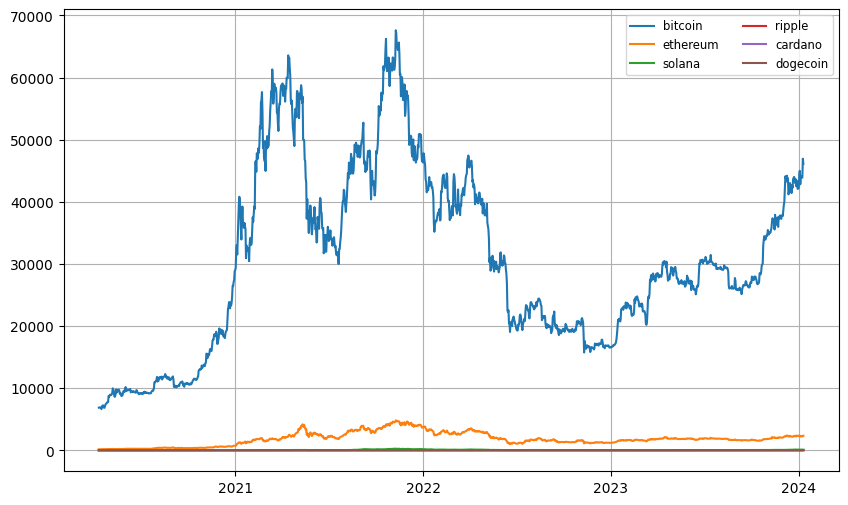

In [ ]:
df = crypto_df.copy()
df.dropna(inplace = True)

from matplotlib.dates import YearLocator

# Assuming df has a datetime index, if not, convert it to datetime index
# df.index = pd.to_datetime(df.index)

plt.figure(figsize=(10, 6))

cryptos = ['bitcoin', 'ethereum', 'solana', 'ripple', 'cardano', 'dogecoin']
for x in cryptos:
  plt.plot(df.index, df[x], label=x)

# Set x-axis ticks at yearly intervals
plt.gca().xaxis.set_major_locator(YearLocator())
plt.legend(loc='upper right', ncol=2, fontsize='small')
plt.grid()
plt.show()

In [ ]:
df = pd.DataFrame({'date': dates, f'price': prices})
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.date
df.set_index('date', inplace = True)

In [ ]:
df['PC'] = df['price'].pct_change()

In [ ]:
(df['PC'] < -0.1).sum()

59

In [ ]:
df.sort_values(by = "PC")

price        PC
date                              
2020-03-13   5142.990459 -0.351903
2015-01-14    172.147900 -0.222584
2013-12-07    811.980000 -0.203676
2017-09-14   3100.668155 -0.201610
2013-12-18    559.360000 -0.191267
...                  ...       ...
2017-07-20   2766.825119  0.216389
2013-05-04    111.250000  0.222393
2015-01-15    210.555900  0.223110
2017-12-07  18491.181554  0.332556
2013-04-28    135.300000       NaN

[3909 rows x 2 columns]

In [ ]:
scaler = MinMaxScaler()
scaler.fit(df[['bitcoin']])

for x in cryptos:
  df[[x]] = scaler.transform(df[[x]])

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- ethereum
Feature names seen at fit time, yet now missing:
- bitcoin


In [ ]:
dfPrice = pd.DataFrame({
    'price': prices,
    'volume': volumes,
    'market_cap': market_caps},
     index=pd.to_datetime(dates))

dfPrice.index = dfPrice.index.date
dfPrice.index = pd.to_datetime(dfPrice.index)
dfPrice.index.name = 'date'

In [ ]:
dfPrice['change'] = dfPrice['price'].pct_change() * 100
dfPrice.sort_values(by = 'change').head()

In [ ]:
dfPrice.loc["2020-03-12": "2020-03-14"]

In [ ]:
dfPrice.head(1)

In [ ]:
plt.figure(figsize=(10, 6))  # Adjust the values in figsize to make the plot wider or narrower
plt.plot(dfPrice['price'])
plt.grid()
plt.title('Bitcoin Price Through The Year (in USD)')
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()

In [ ]:
df = pd.read_csv("multiTimeline.csv")
input = df['Category: All categories'].iloc[1:]
df2 = pd.DataFrame()
df2['trend'] = input
df2['date'] = pd.date_range(start='2016-01', end='2024-02', freq='M')
df2.set_index('date', inplace = True)
# df2.head()
df2.sort_index(inplace=True)
df2['trend'] = df2['trend'].astype(int)

In [ ]:
plt.figure(figsize=(10, 6))  # Adjust the values in figsize to make the plot wider or narrower
plt.plot(df2.loc['2018-12-31':]['trend'])
plt.grid()
plt.title('Bitcoin Trend Through The Year (By Google Trends)')
plt.ylabel('Trend')
plt.xlabel('Date')
plt.show()

### Trends

In [ ]:
tipes = {"Day": str,
         "bitcoin: (Worldwide)" : int}

dfTrends = pd.read_csv(f"./Skripsi/Trends/multiTimeline ({0}).csv", dtype = tipes, skiprows=1)
for x in np.arange(7):
  temp = pd.read_csv(f"./Skripsi/Trends/multiTimeline ({x+1}).csv", dtype = tipes, skiprows=1)
  # print(temp.head(1))
  temp2 = pd.merge(dfTrends, temp, on='Day', how='inner')
  # print(len(temp2))
  tempVar = temp2.iloc[0][1] / temp2.iloc[0][2]
  temp['bitcoin: (Worldwide)'] = temp['bitcoin: (Worldwide)'].apply(lambda x: x * tempVar)
  dfTrends = pd.concat([temp[:269], dfTrends])

dfTrends.rename(columns = {"bitcoin: (Worldwide)" : "trend", "Day" : "date"}, inplace = True)
dfTrends['date'] = pd.to_datetime(dfTrends['date'])
dfTrends.drop_duplicates(inplace = True)
dfTrends.set_index("date", inplace = True)
# dfTrends

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 100))

# Fit and transform the data
dfTrends['trend'] = scaler.fit_transform(dfTrends)

### Combine Them All!

In [ ]:
dfSenCount = dfSen.groupby('date').mean()
scaler = MinMaxScaler(feature_range=(-1, 1))
dfSenCount['sen'] = scaler.fit_transform(dfSenCount)
dfPrice = dfPrice[dfTrends.index.min() : dfTrends.index.max()]

In [ ]:
# Create a date range covering the entire period
start_date = dfSenCount.index.min()
end_date = dfSenCount.index.max()
date_range = pd.date_range(start_date, end_date)

# Reindex the DataFrame to include missing dates
dfSenCount = dfSenCount.reindex(date_range)

# Fill missing values with the mean of the surrounding data
dfSenCount.interpolate(method = 'linear', inplace = True)
# dfSenCount['sen'] = dfSenCount['sen'].fillna((dfSenCount['sen'].shift() + dfSenCount['sen'].shift(-1)) / 2)

In [ ]:
# Create a date range covering the entire period
start_date = dfTrends.index.min()
end_date = dfTrends.index.max()
date_range = pd.date_range(start_date, end_date)

# Identify missing dates
print(date_range[~date_range.isin(dfPrice.index)])
print(date_range[~date_range.isin(dfSenCount.index)])
print(date_range[~date_range.isin(dfTrends.index)])

In [ ]:
df = pd.concat([dfPrice, dfSenCount, dfTrends], axis = 1)
df.drop(['change', 'market_cap'], axis = 1, inplace = True)
df.head()

In [ ]:
df.index.name = 'date'

In [ ]:
df.head()

In [ ]:
df.to_csv("dataRaw.csv")

## Sentiment Analysis


In [ ]:
dfGt = preprocess_dataframe(dfGt, 3)
dfGtH = preprocess_dataframe(dfGtH, 3)
dfT = preprocess_dataframe(dfT, 5)

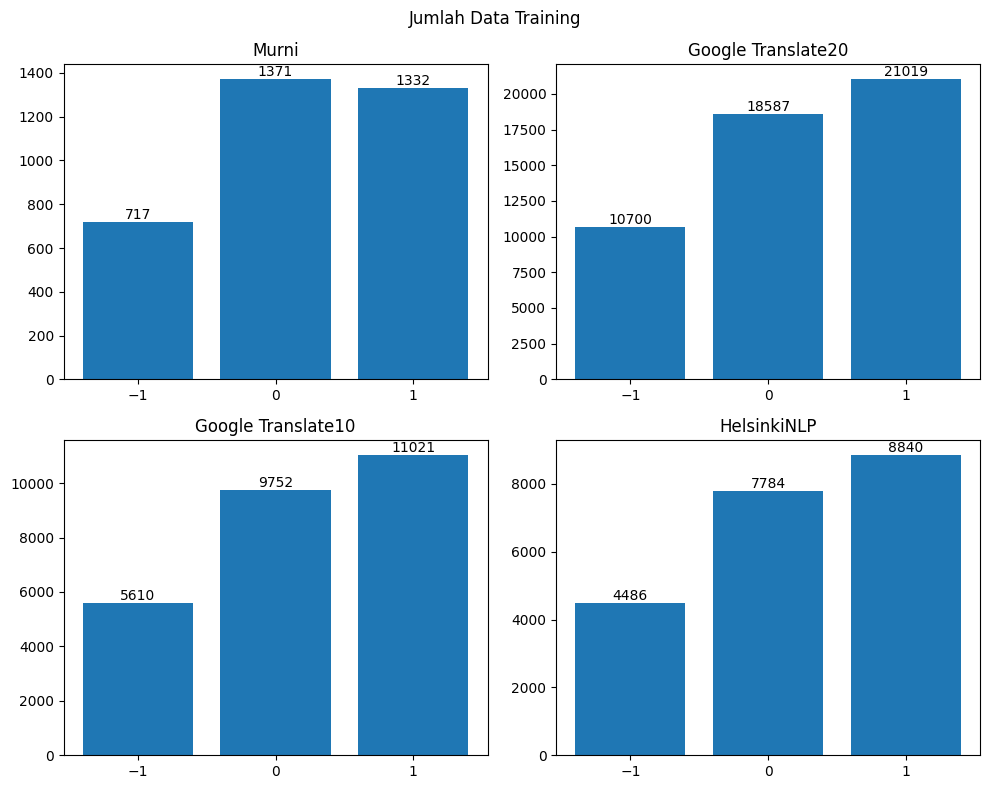

In [ ]:
import matplotlib.pyplot as plt

dfList = (df, dfGt, dfGtH, dfT)
dfName = ['Murni',
          'Google Translate20',
          'Google Translate10',
          'HelsinkiNLP']

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

for i, x in enumerate(dfList):
    number_counts = x['sen'].value_counts()
    bars = ax[i // 2, i % 2].bar(number_counts.index, number_counts.values)

    for bar in bars:
        yval = bar.get_height()
        ax[i // 2, i % 2].text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

    ax[i // 2, i % 2].xaxis.set_ticks([-1, 0, 1])
    ax[i // 2, i % 2].set_title(dfName[i])

fig.suptitle("Jumlah Data Training")
plt.tight_layout()
plt.show()

In [ ]:
dfTrain = preprocess_dataframe2(dfTrain)
dfGt = preprocess_dataframe2(dfGt)
dfGtH = preprocess_dataframe2(dfGtH)
dfT = preprocess_dataframe2(dfT)

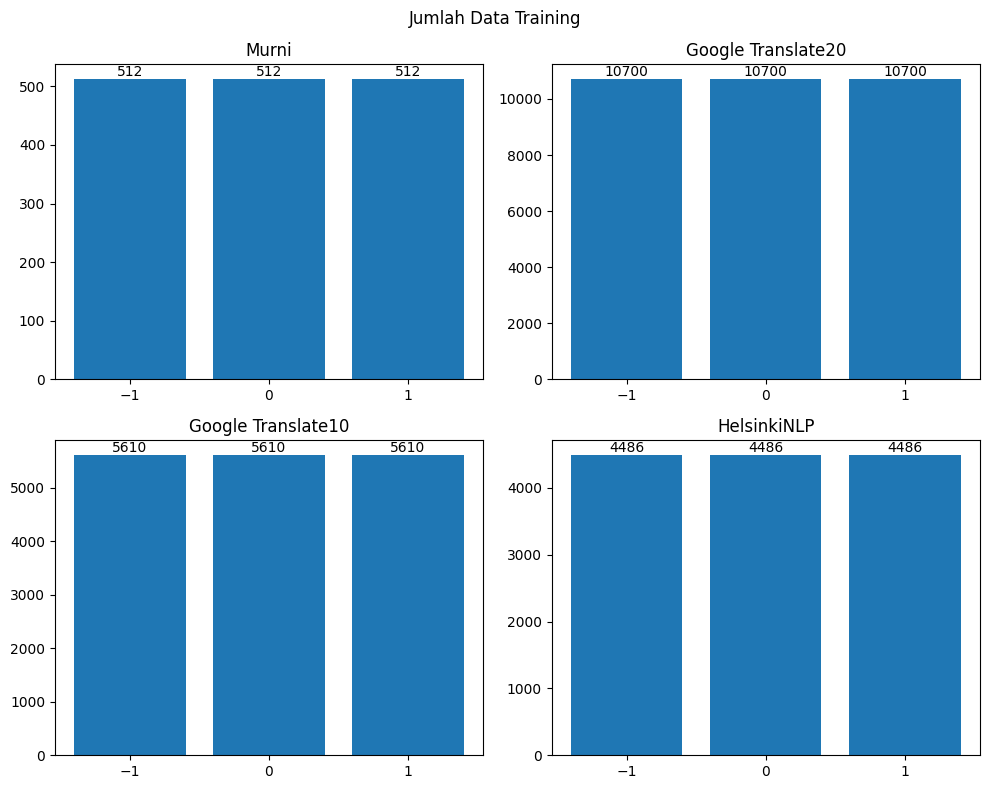

In [ ]:
import matplotlib.pyplot as plt

dfList = (dfTrain, dfGt, dfGtH, dfT)
dfName = ["Murni",
          'Google Translate20',
          'Google Translate10',
          'HelsinkiNLP']

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

for i, x in enumerate(dfList):
    number_counts = x['sen'].value_counts()
    bars = ax[i // 2, i % 2].bar(number_counts.index, number_counts.values)

    for bar in bars:
        yval = bar.get_height()
        ax[i // 2, i % 2].text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

    ax[i // 2, i % 2].xaxis.set_ticks([-1, 0, 1])
    ax[i // 2, i % 2].set_title(dfName[i])

fig.suptitle("Jumlah Data Training")
plt.tight_layout()
plt.show()

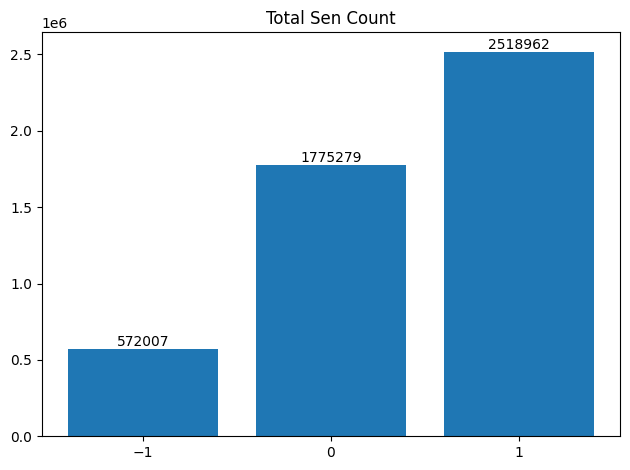


 1    2518962
 0    1775279
-1     572007
Name: sen, dtype: int64


In [ ]:
number_counts = dfSen['sen'].value_counts()
bars = plt.bar(number_counts.index, number_counts.values)

plt.bar_label(bars, fmt='%d')

plt.xticks([-1, 0, 1])
plt.title("Total Sen Count")

plt.tight_layout()
plt.show()
print(f"\n{number_counts}")

### Sentiment Model

In [ ]:
!pip install transformers -q
import torch
import random
from transformers import AutoTokenizer, RobertaForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 69420
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

f = open("Skripsi/cryptoVocab.txt", "r")
crypto_vocabulary = f.read().split(',')
crypto_vocabulary = [term.replace('"', '') for term in crypto_vocabulary]

def sentiment_score(review, length):
    # Tokenize the review outside the loop
    tokens = tokenizer(review, return_tensors='pt', max_length = length, truncation = True).input_ids.to(device)

    # Pass the tokens directly to the model for batch processing
    result = model(tokens)

    # Convert the tensor to a numpy array and extract the predicted sentiment
    sentiment = int(torch.argmax(result.logits)) - 1

    return sentiment

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_i

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import concurrent
import time as time
import random
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

modelList3 = ['cardiffnlp/twitter-roberta-base-sentiment-latest',  #512
              'finiteautomata/bertweet-base-sentiment-analysis',   #128
              'ProsusAI/finbert',                                  #512
              'cardiffnlp/twitter-xlm-roberta-base-sentiment',     #512
              'ElKulako/cryptobert',                               #512
              'svalabs/twitter-xlm-roberta-bitcoin-sentiment',     #512
              'AfterRain007/cryptobertRefined']                    #128

seed = 69420
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

time3 = []
dfFull = pd.DataFrame()

for x in modelList3[:6]:
    # Create a ThreadPoolExecutor with desired number of workers
    ## To make sentiment analysis faster
    ### Gotta go fast!

    tokenizer = AutoTokenizer.from_pretrained(x)
    try:
      new_tokens = set(crypto_vocabulary) - set(tokenizer.vocab.keys())
    except:
      new_tokens = set(crypto_vocabulary) - set(tokenizer.get_vocab().keys())
    tokenizer.add_tokens(list(new_tokens))

    model = AutoModelForSequenceClassification.from_pretrained(x)
    model.to(device)
    model.resize_token_embeddings(len(tokenizer))
    torch.cuda.empty_cache()

    start = time.time()

    if (x == 'finiteautomata/bertweet-base-sentiment-analysis'):
      sentiment_result = dfTest['text'].apply(sentiment_score, args=(128, ))
    else:
      sentiment_result = dfTest['text'].apply(sentiment_score, args=(512, ))

    dfFull[x.split('/')[-1]] = sentiment_result

modelName = "AfterRain007/cryptobertRefined"
tokenizer = AutoTokenizer.from_pretrained(modelName)
model     = RobertaForSequenceClassification.from_pretrained(modelName)
model.to(device)
torch.cuda.empty_cache()
dfFull[modelName.split('/')[-1]] = dfTest['text'].apply(sentiment_score, args=(128,))

KeyboardInterrupt: 

In [ ]:
dfFull['sen'] = dfTest['sen'].copy()
# Define sentiment values
sentiments = [-1, 0, 1]

fig, ax = plt.subplots(2, 3, figsize=(14, 8))

# Define the column names
columns = ["Model", "Acc Negative Sentiment", "Acc Neutral Sentiment", "Acc Positive Sentiment", "Overall Accuracy", "Time Cost"]

# Create an empty DataFrame
accDf = pd.DataFrame(columns=columns)

y_test = dfTest['sen']
for i, x in enumerate(modelList3[:6]):
    y_pred = dfFull[x.split('/')[-1]]
    cm = confusion_matrix(y_pred, y_test)

    # Create a heatmap
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1], ax=ax[i // 3, i % 3])
    ax[i // 3, i % 3].set_title(x.split('/')[-1])
    ax[i // 3, i % 3].set_xlabel("Actual Sentiment")
    ax[i // 3, i % 3].set_ylabel("Predicted Sentiment")

plt.suptitle("All Model Confusion Matrix", fontsize = 13)
plt.tight_layout()
# plt.subplots_adjust(hspace=0.25)
plt.show()

In [ ]:
dfFull['sen'] = dfTest['sen'].copy()

# Define the column names
columns = ["Model", "Acc Negative Sentiment", "Acc Neutral Sentiment", "Acc Positive Sentiment", "Overall Accuracy"]

# Create an empty DataFrame
accDf = pd.DataFrame(columns=columns)

for i, x in enumerate(modelList3):
  modelName = x.split('/')[-1]
  accOvr = len(dfFull[(dfFull[modelName]) == dfFull['sen']]) / 300
  accNeg = len(dfFull[(dfFull[modelName]==-1) & (dfFull['sen']==-1)]) / 100
  accNeu = len(dfFull[(dfFull[modelName]== 0) & (dfFull['sen']== 0)]) / 100
  accPos = len(dfFull[(dfFull[modelName]== 1) & (dfFull['sen']== 1)]) / 100
  rowData = [modelName] + [accNeg] + [accNeu] + [accPos] + [accOvr]
  accDf.loc[i] = rowData

accDf.to_excel("accuracyOverall.xlsx", index = False)
accDf

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Calculate accuracy
accuracy = accuracy_score(dfFull['sen'], dfFull[modelName])

# Generate a classification report
classification_report_result = classification_report(dfFull['sen'], dfFull[modelName], target_names=["-1", "0", "1"])

# Print the results
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report_result)

In [ ]:
y_test = dfTest['sen']
y_pred = dfFull[modelName]

# Create a confusion matrix
cm = confusion_matrix(y_pred, y_test)

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel('Actual Sentiment')
plt.ylabel('Predicted Sentiment')
plt.title('Confusion Matrix')
plt.show()

## Time Series

### Surface

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dfScaled = transform(None, None)
print("\n", dfScaled.head())


                price    volume       sen     trend
date                                              
2017-12-03  0.124845  0.026206  0.506438  0.285838
2017-12-04  0.130719  0.011891  0.363684  0.327238
2017-12-05  0.139093  0.011416  0.467019  0.347939
2017-12-06  0.165525  0.022409  0.429385  0.461791
2017-12-07  0.237181  0.086509  0.415270  0.989650


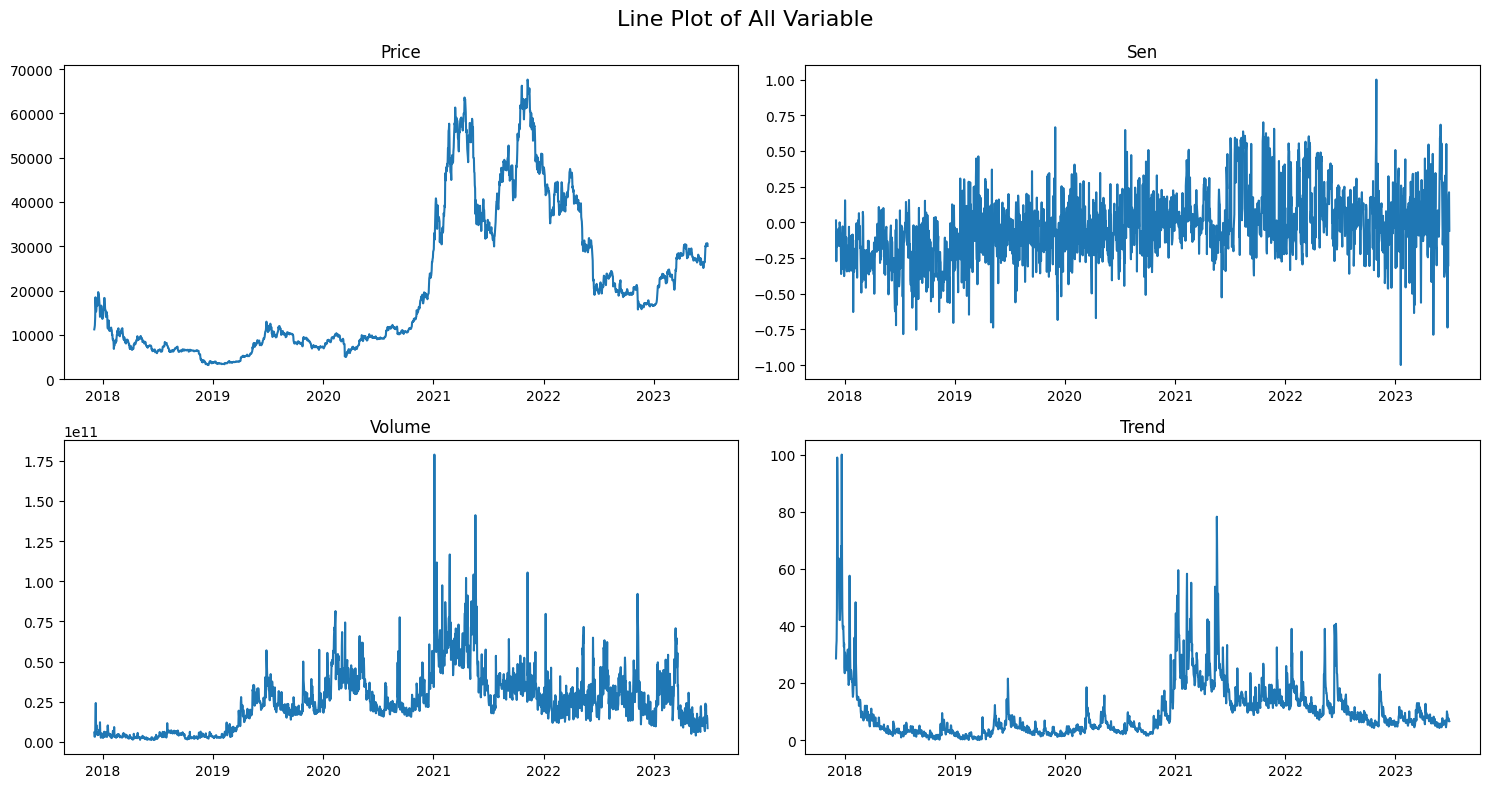

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15, 8))

for i, x in enumerate(df.columns):
  ax[i%2, (i // 2) % 2].plot(df.index, df[x])
  ax[i%2, (i // 2) % 2].set_title(x.capitalize())

fig.suptitle('Line Plot of All Variable', fontsize=16)

plt.tight_layout()
plt.show()

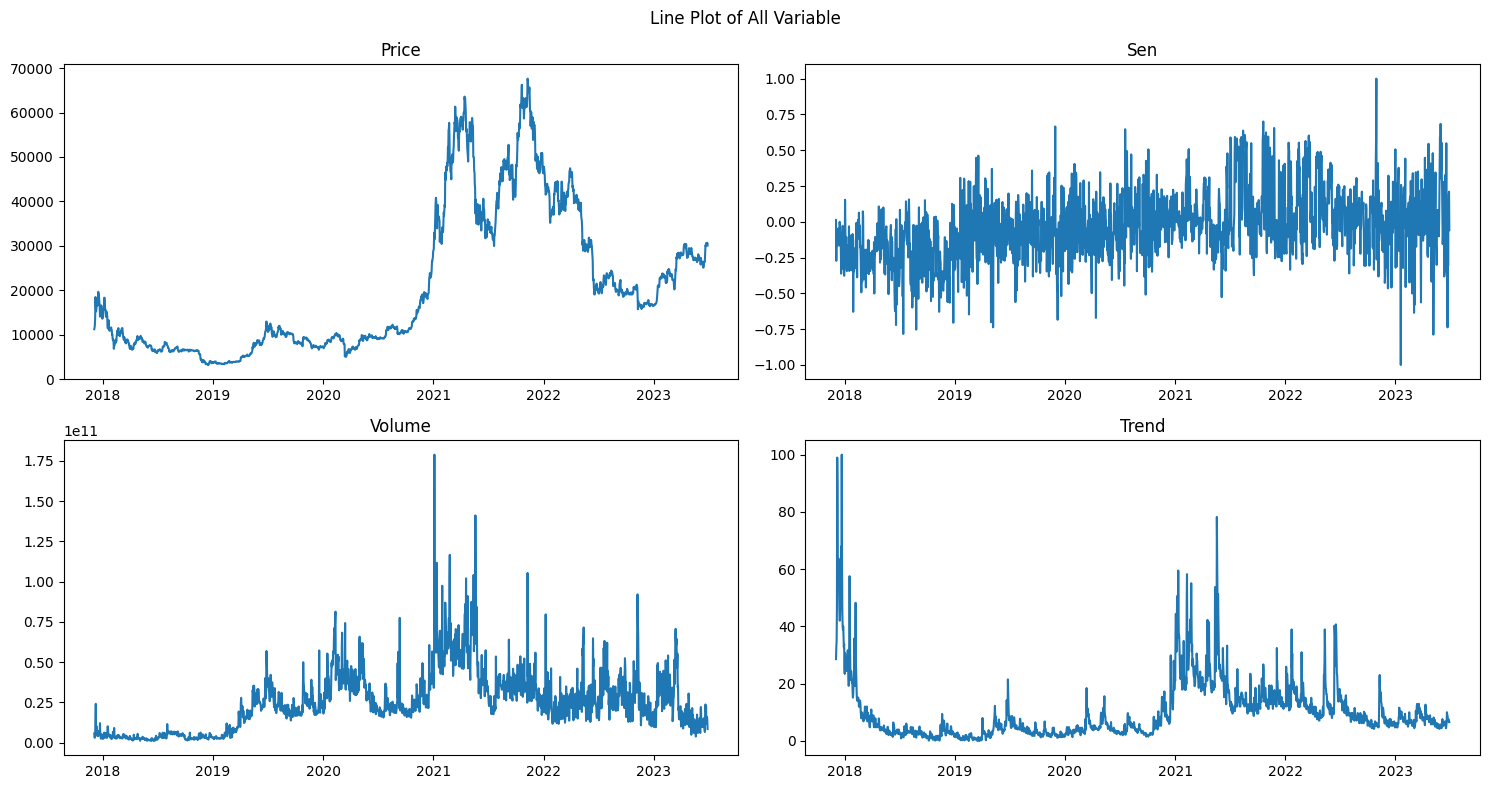

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15, 8))

for i, x in enumerate(df.columns):
  ax[i%2, (i // 2) % 2].plot(df.index, df[x])
  ax[i%2, (i // 2) % 2].set_title(x.capitalize())

fig.suptitle('Line Plot of All Variable')

plt.tight_layout()
plt.show()

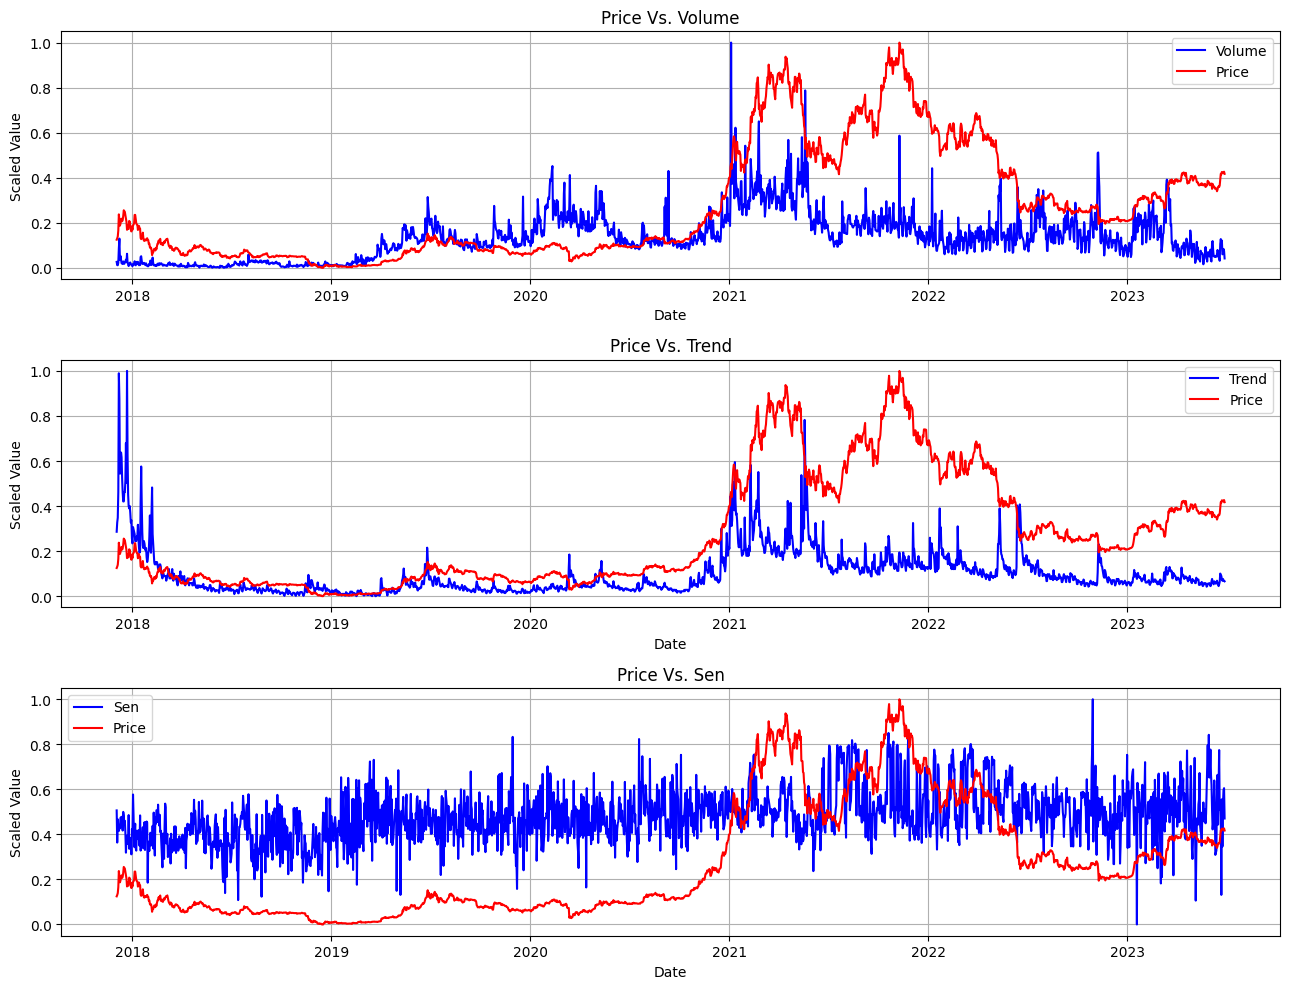

In [ ]:
dfScaled = transform(None, None)
#Variable Vs. Variable
fig, ax = plt.subplots(3, 1, figsize=(13, 10))

for i, x in enumerate(['volume', 'trend', 'sen']):
  ax[i].plot(dfScaled.index, dfScaled[x], label=x.capitalize(), color='blue')
  ax[i].plot(dfScaled.index, dfScaled['price'], label='Price',  color='red')
  ax[i].set(xlabel='Date', ylabel='Scaled Value', title=f'Price and {x.capitalize()}')
  ax[i].legend(), ax[i].grid(True)
  ax[i].set_title(f'Price Vs. {x.capitalize()}')

plt.tight_layout()
plt.show()

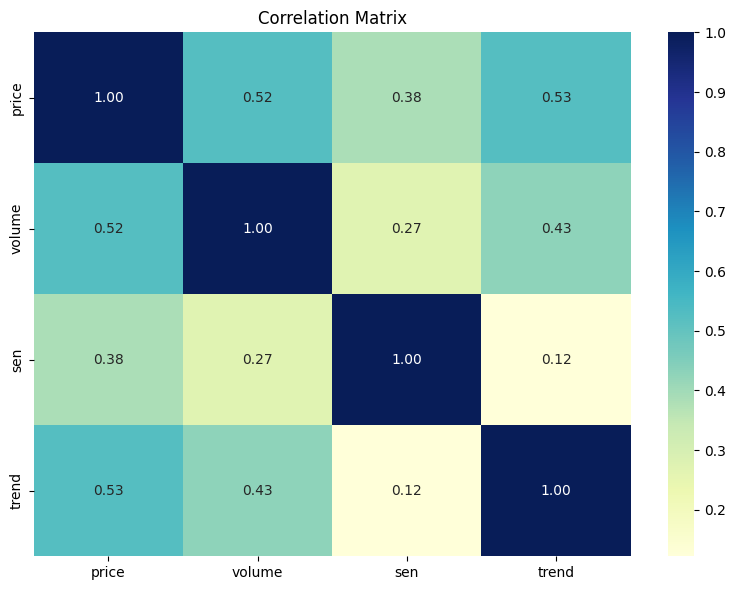

In [ ]:
#Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu", fmt=".2f", xticklabels=df.corr().index, yticklabels=df.corr().index)
plt.title("Correlation Matrix")

plt.tight_layout()
plt.show()

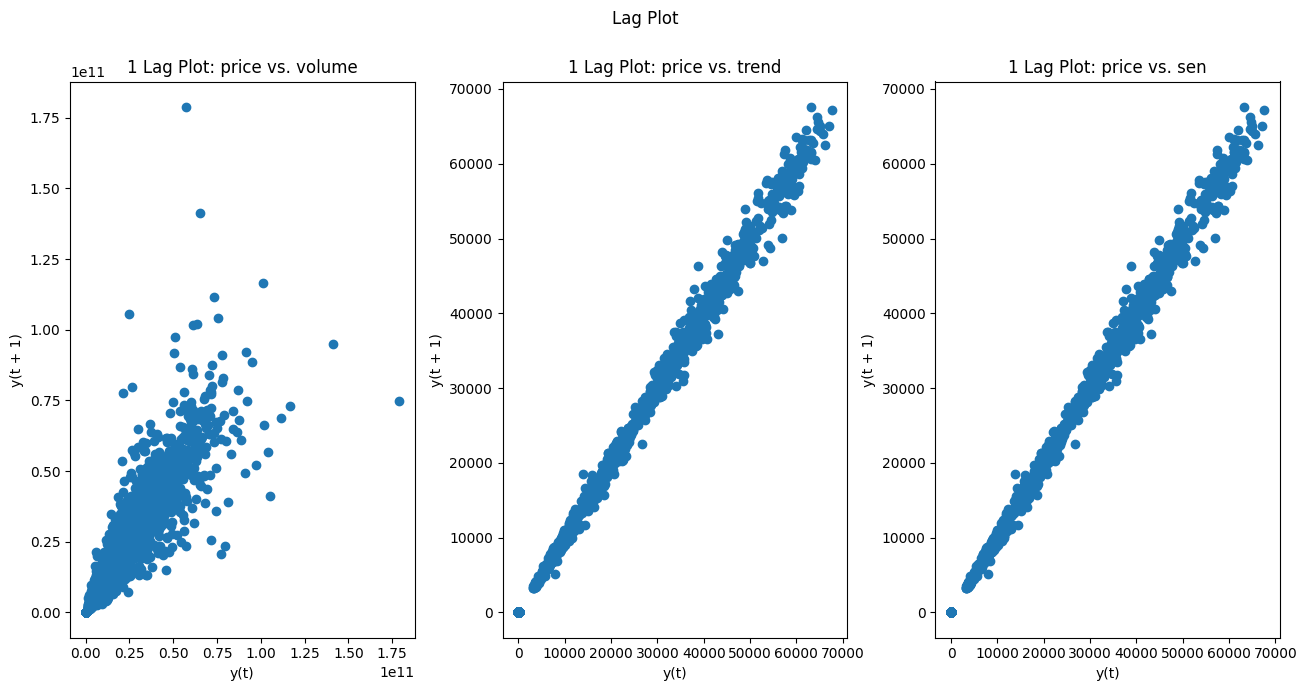

In [ ]:
#Lag Plot
fig, ax = plt.subplots(1, 3, figsize=(13, 7))

for i, x in enumerate(['volume', 'trend', 'sen']):
  pd.plotting.lag_plot(df[['price', x]], lag=1, ax=ax[i])
  ax[i].set_title(f'1 Lag Plot: price vs. {x}')

fig.suptitle('Lag Plot')
plt.tight_layout()
plt.show()

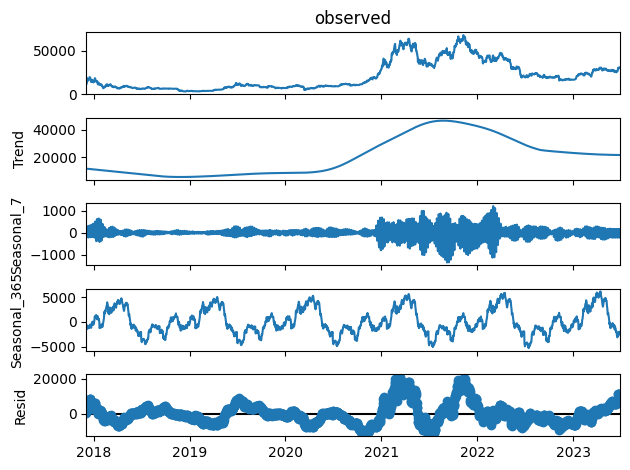

In [ ]:
from statsmodels.tsa.seasonal import MSTL
stl_kwargs = {"seasonal_deg": 0}

model = MSTL(df['price'], periods=(7, 365), stl_kwargs=stl_kwargs)
res = model.fit()

res.plot()
plt.tight_layout()
plt.show()

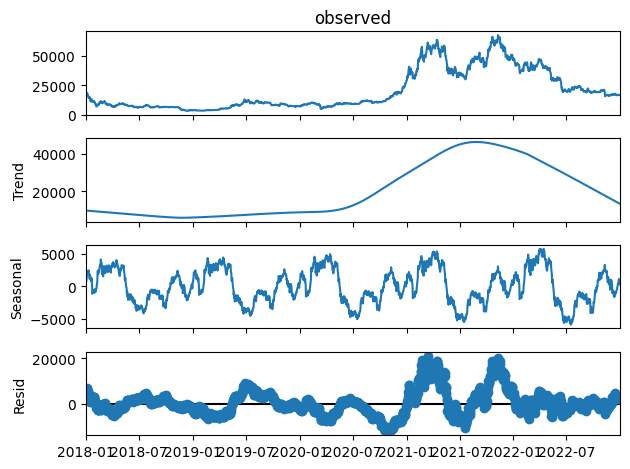

In [ ]:
dfTemp = df.loc['2018':'2022'].copy()
from statsmodels.tsa.seasonal import MSTL
stl_kwargs = {"seasonal_deg": 0}
model = MSTL(dfTemp['price'], periods=(365), stl_kwargs=stl_kwargs)
res = model.fit()
res.plot()
plt.tight_layout()
plt.show()

### Detailed

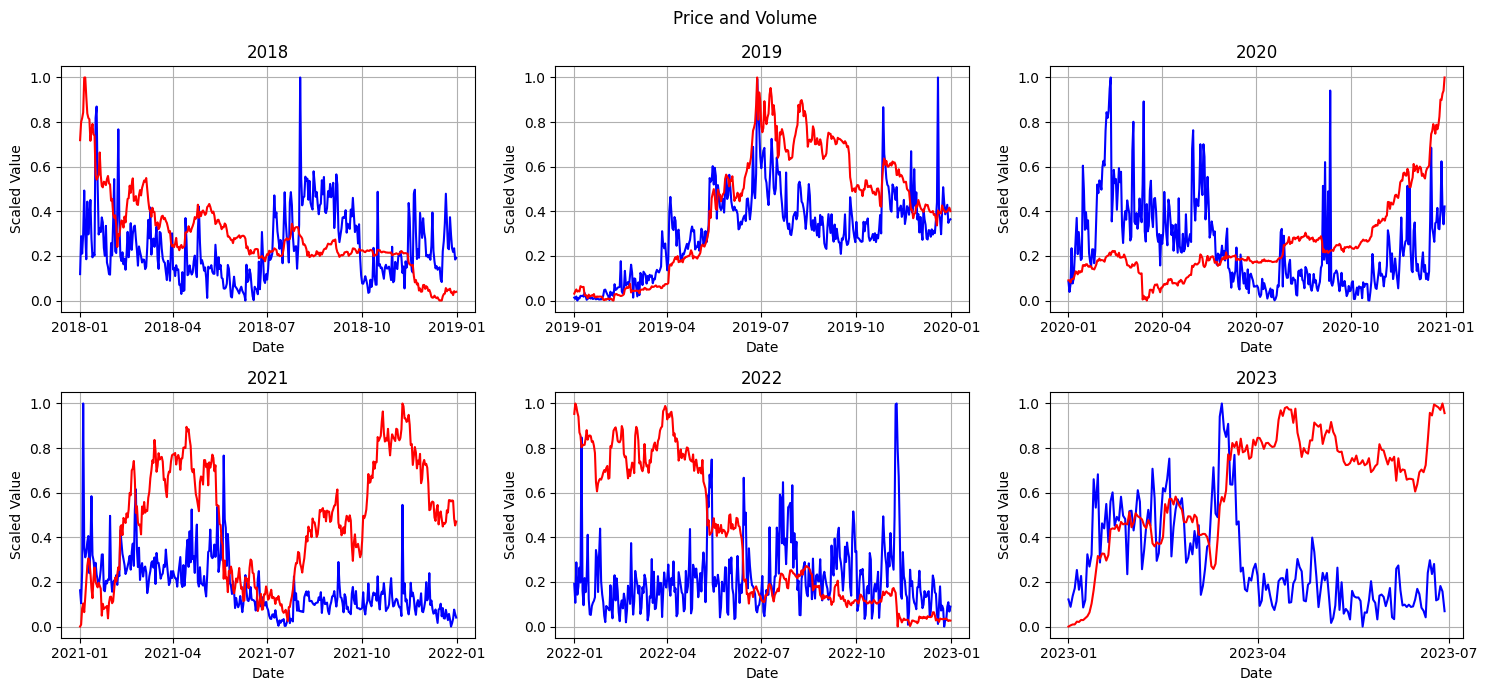

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator

# Create a figure with two subplots side by side
fig, ax = plt.subplots(2, 3, figsize=(15, 7))

for i, x in enumerate(df.index.year.unique()[1:]):
    temp = transform(str(x), 0)
    ax[i // 3, i % 3].plot(temp.index, temp['volume'], label='Volume', color='blue')
    ax[i // 3, i % 3].plot(temp.index, temp['price'], label='Price', color='red')

    ax[i // 3, i % 3].set(xlabel='Date', ylabel='Scaled Value', title=str(x))
    ax[i // 3, i % 3].xaxis.set_major_locator(MonthLocator(bymonth=[1, 4, 7, 10]))
    ax[i // 3, i % 3].grid(True)

# Adjust spacing between subplots
plt.suptitle("Price and Volume")
plt.tight_layout()

# Show the plots
plt.show()

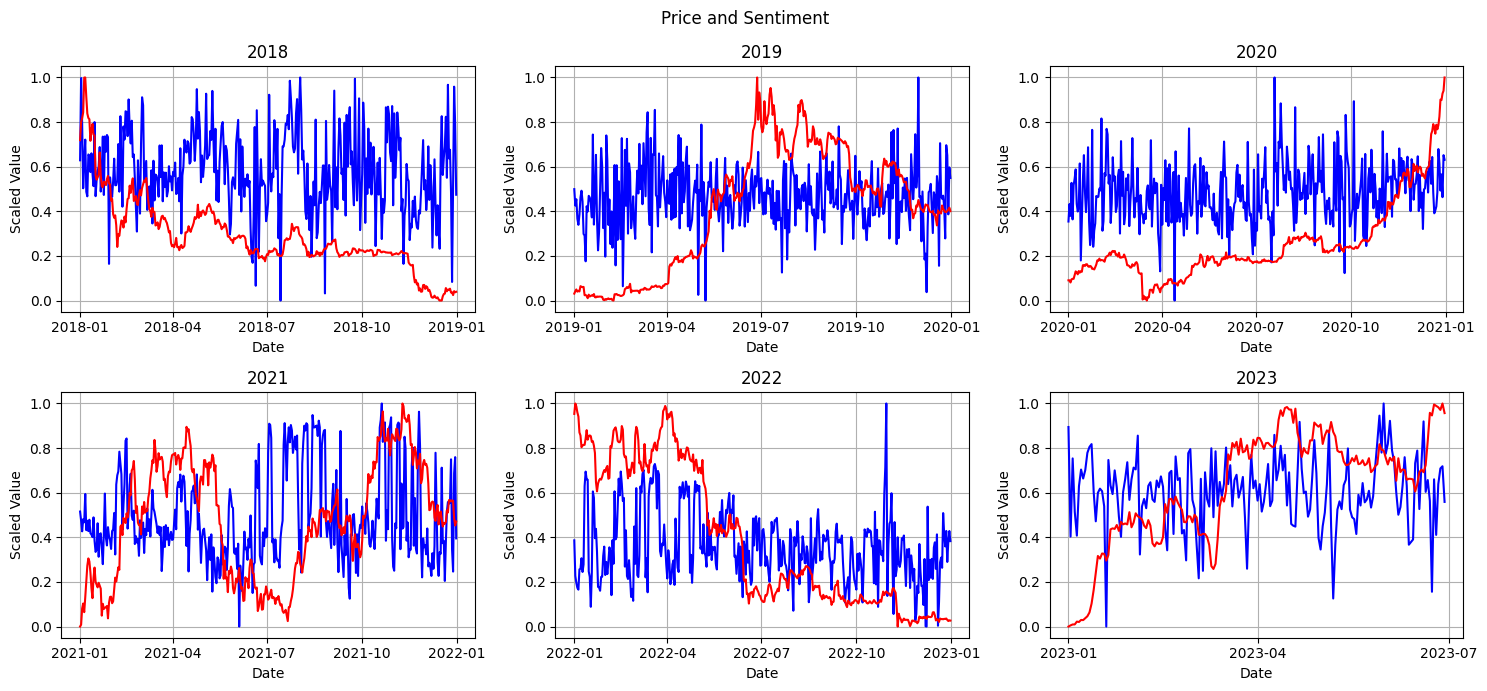

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator

# Create a figure with two subplots side by side
fig, ax = plt.subplots(2, 3, figsize=(15, 7))

for i, x in enumerate(df.index.year.unique()[1:]):
    temp = transform(str(x), 0)
    ax[i // 3, i % 3].plot(temp.index, temp['sen'], label='Sentiment', color='blue')
    ax[i // 3, i % 3].plot(temp.index, temp['price'], label='Price', color='red')

    ax[i // 3, i % 3].set(xlabel='Date', ylabel='Scaled Value', title=str(x))
    ax[i // 3, i % 3].xaxis.set_major_locator(MonthLocator(bymonth=[1, 4, 7, 10]))
    ax[i // 3, i % 3].grid(True)

# Adjust spacing between subplots
plt.suptitle("Price and Sentiment")
plt.tight_layout()

# Show the plots
plt.show()

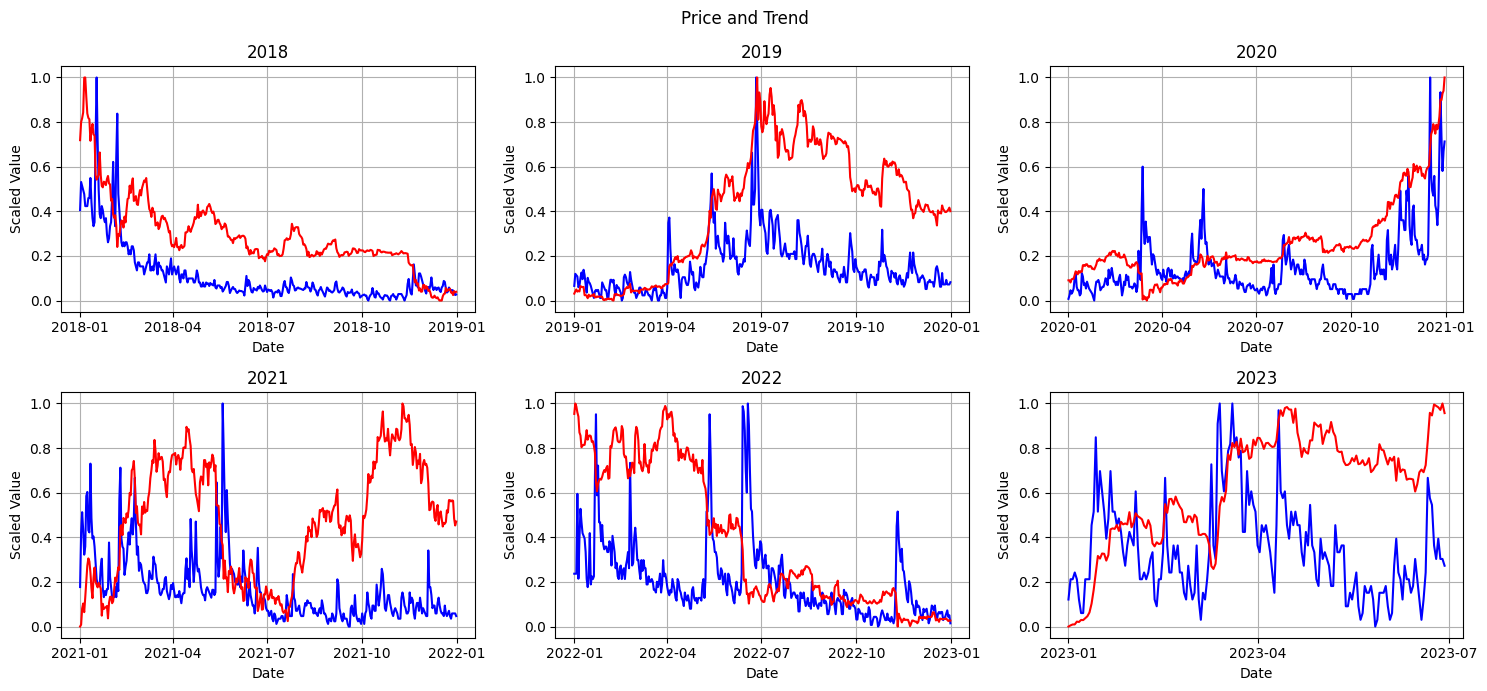

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator

# Create a figure with two subplots side by side
fig, ax = plt.subplots(2, 3, figsize=(15, 7))

for i, x in enumerate(df.index.year.unique()[1:]):
    temp = transform(str(x), 0)
    ax[i // 3, i % 3].plot(temp.index, temp['trend'], label='Trend', color='blue')
    ax[i // 3, i % 3].plot(temp.index, temp['price'], label='Price', color='red')

    ax[i // 3, i % 3].set(xlabel='Date', ylabel='Scaled Value', title=str(x))
    ax[i // 3, i % 3].xaxis.set_major_locator(MonthLocator(bymonth=[1, 4, 7, 10]))
    ax[i // 3, i % 3].grid(True)

# Adjust spacing between subplots
plt.suptitle("Price and Trend")
plt.tight_layout()

# Show the plots
plt.show()

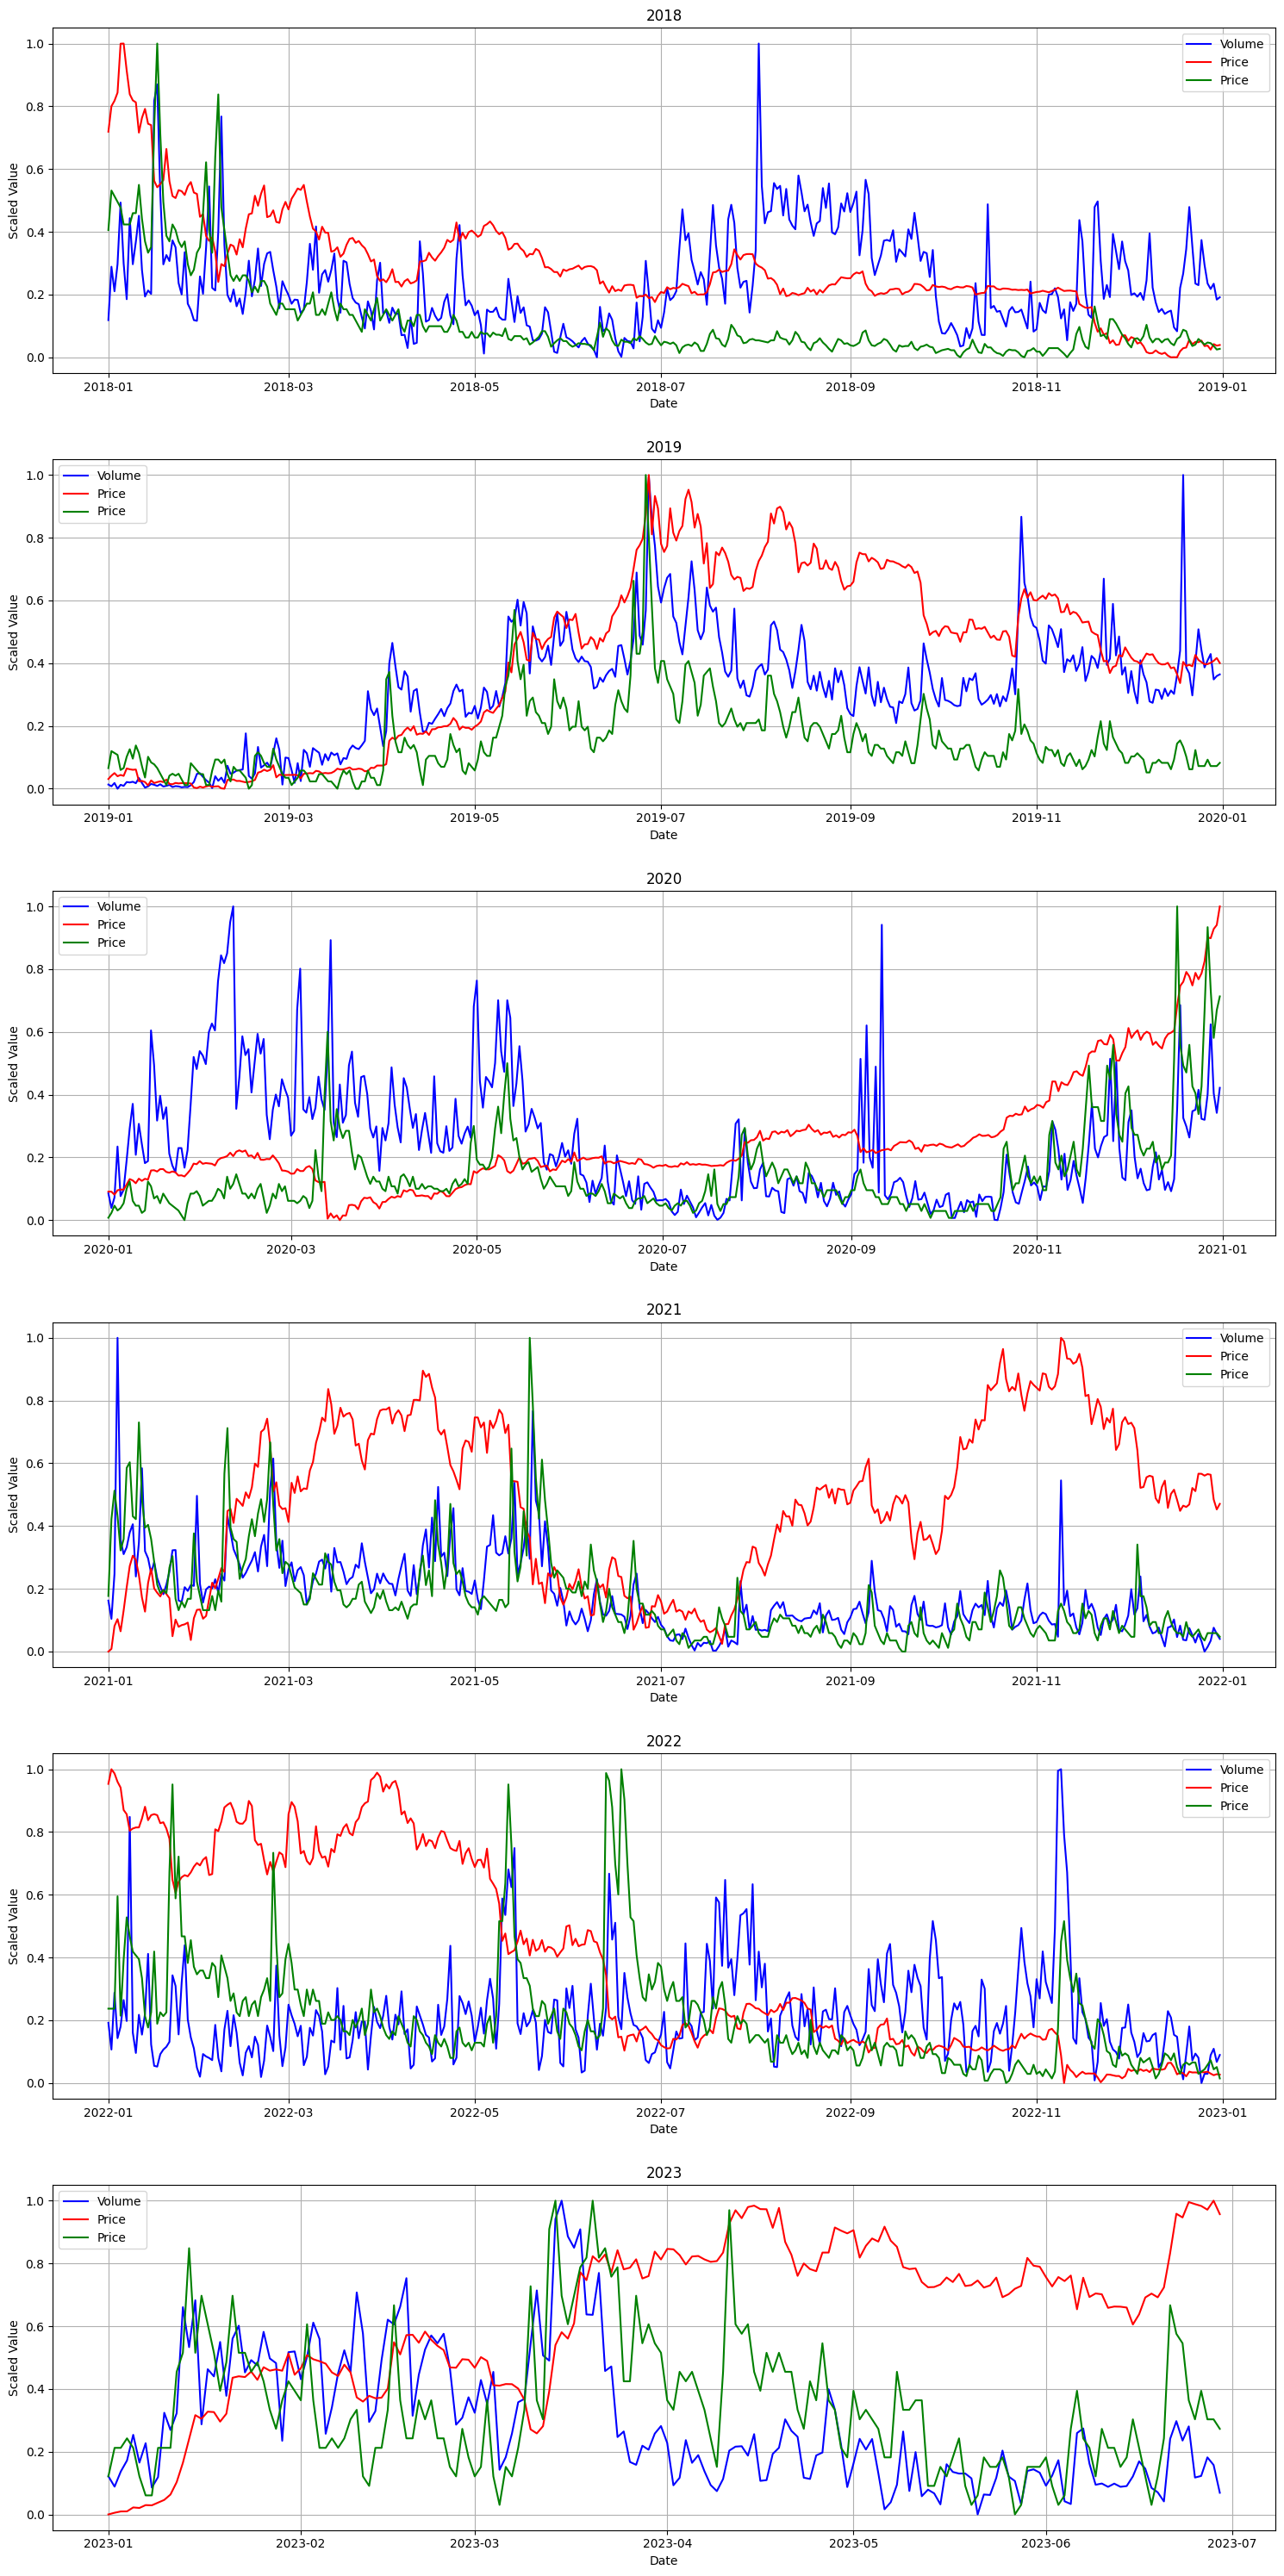

In [ ]:
# Create a figure with two subplots side by side
fig, ax = plt.subplots(6, 1, figsize=(15, 30))

for i, x in enumerate(df.index.year.unique()[1:]):
  temp = transform(str(x), 0)
  ax[i].plot(temp.index, temp['volume'], label='Volume', color='blue')
  ax[i].plot(temp.index, temp['price'], label='Price', color='red')
  # ax[i].plot(temp.index, temp['sen'], label='Volume', color='magenta')
  ax[i].plot(temp.index, temp['trend'], label='Price', color='green')

  ax[i].set(xlabel='Date', ylabel='Scaled Value', title=x)
  ax[i].legend()
  ax[i].grid(True)

# Adjust spacing between subplots
plt.tight_layout()

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.25)

# Show the plots
plt.show()

In [ ]:
df['week'] = df.index.isocalendar().week
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year

dfScaled['week'] = dfScaled.index.isocalendar().week
dfScaled['day'] = dfScaled.index.day
dfScaled['month'] = dfScaled.index.month
dfScaled['year'] = dfScaled.index.year

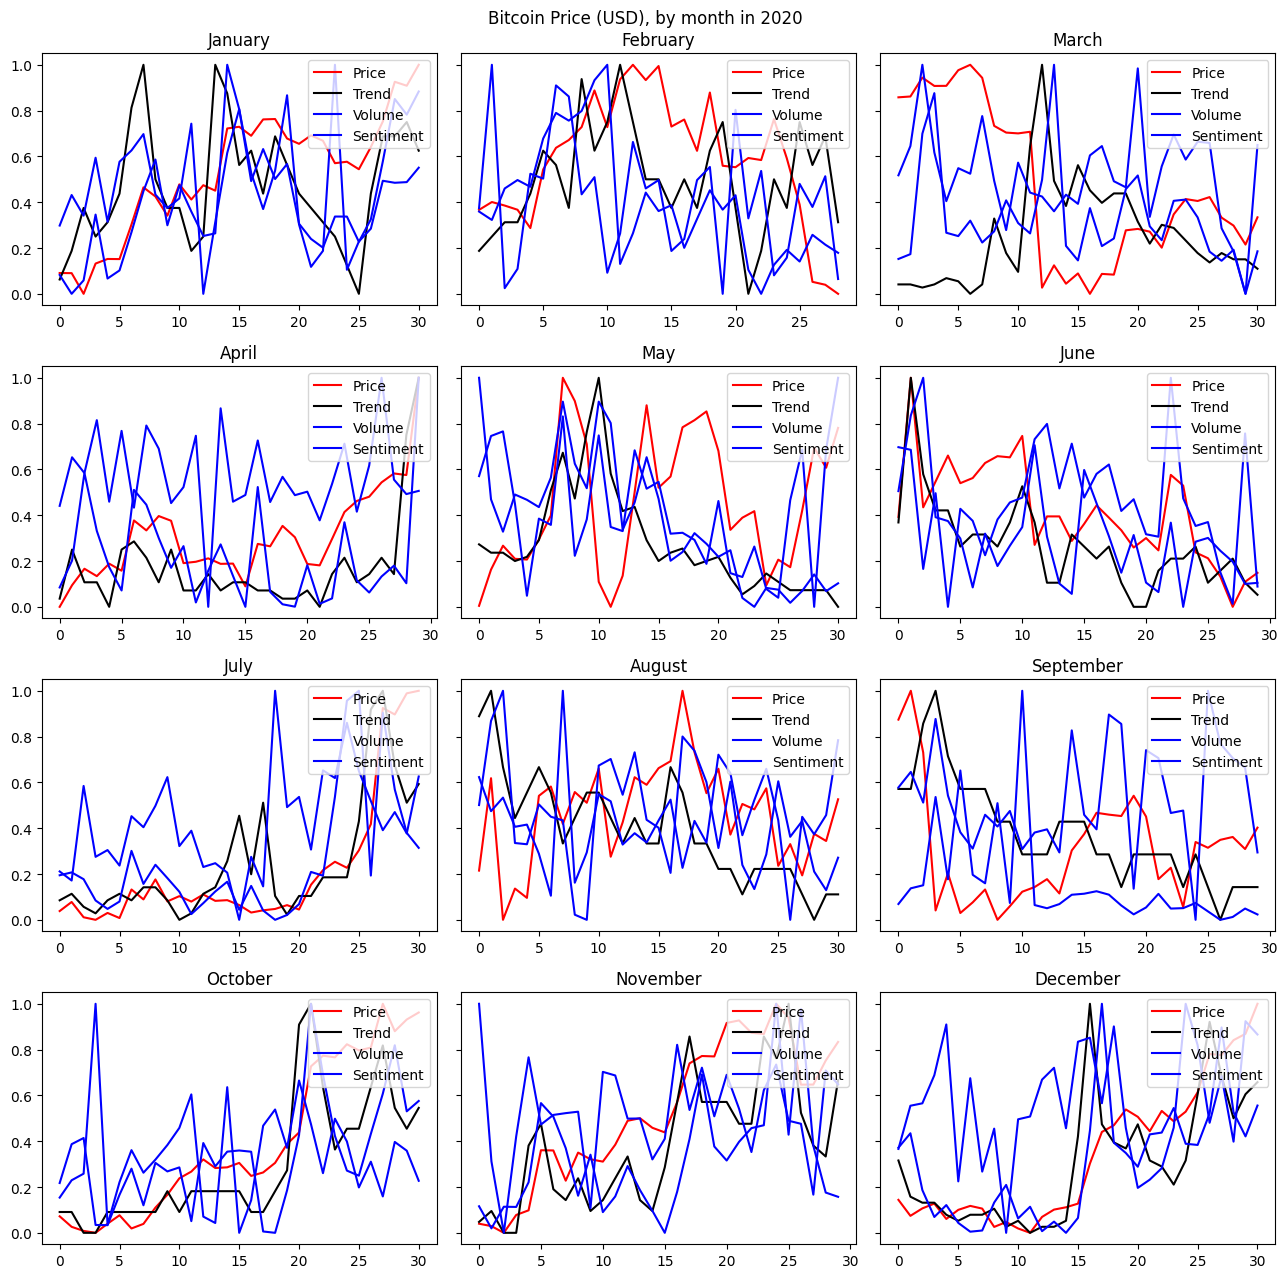

In [ ]:
# Plotty
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=[13, 13], sharey=True)
ax = ax.flatten()
sns_blue = sns.color_palette(as_cmap=True)[0]
MONTHS = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
YEAR = 2020

for ix, month in enumerate(MONTHS):
    temp1 = dfScaled[(dfScaled['year'] == YEAR) & (dfScaled['month'] == ix + 1)]
    temp = scaler.fit_transform(temp1)
    temp = pd.DataFrame(temp,columns=temp1.columns, index=temp1.index)
    temp.reset_index()["price"].plot(ax=ax[ix], color='r', label = 'Price')
    temp.reset_index()["trend"].plot(ax=ax[ix], color='black', label = 'Trend')
    temp.reset_index()["volume"].plot(ax=ax[ix], color='b', label = 'Volume')
    temp.reset_index()["sen"].plot(ax=ax[ix], color='b', label = 'Sentiment')
    ax[ix].set_title(month)
    ax[ix].legend(loc='upper right')

fig.suptitle(f"Bitcoin Price (USD), by month in {YEAR}")
fig.tight_layout()

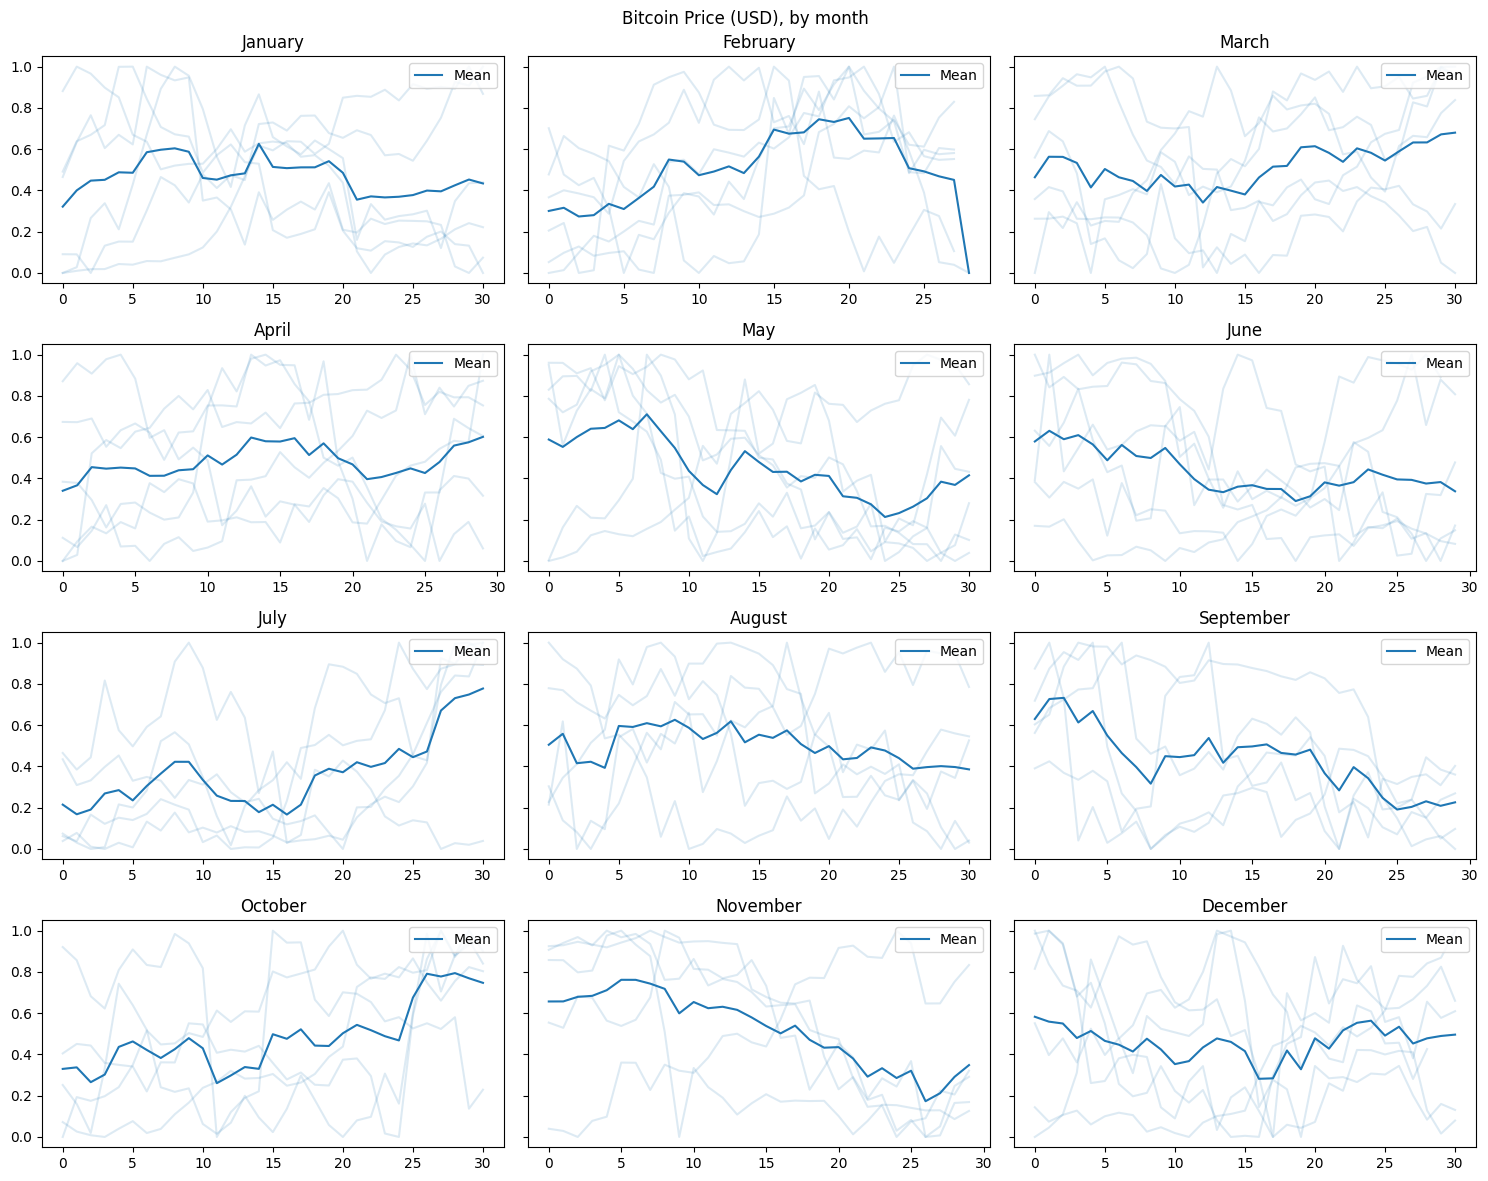

In [ ]:
# Plot the electricity demand for each day
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=[15, 12], sharey=True)
ax = ax.flatten()
sns_blue = sns.color_palette(as_cmap=True)[0]
MONTHS = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

for ix, month in enumerate(MONTHS):
    tempM = pd.DataFrame()
    year = df[df['month'] == ix+1]['year'].unique()
    for i in year:
        temp = df[(df['month'] == ix + 1) & (df['year'] == i)]['price']
        temp = pd.DataFrame(temp)

        temp2 = scaler.fit_transform(temp)
        temp2 = pd.DataFrame(temp2,columns=['price'], index=temp.index)
        temp2.reset_index(drop = True, inplace = True)
        temp2["price"].plot(alpha = 0.15, ax=ax[ix], color=sns_blue, label="_no_legend_")
        tempM = pd.concat((tempM, temp2), axis = 1)

    tempM.mean(axis=1).plot(alpha = 1, ax=ax[ix], color=sns_blue, label="Mean")
    ax[ix].legend(loc='upper right')
    ax[ix].set_title(month)


fig.suptitle("Bitcoin Price (USD), by month")
fig.tight_layout()

### Outlier

#### Starting Out

In [ ]:
# # Create a figure with three subplots in a vertical layout
# fig, axes = plt.subplots(1, 4, figsize=(12, 4))

# for i, x in enumerate(['price', 'volume', 'sen', 'trend']):
#   axes[i].boxplot(df[x], vert=True)
#   axes[i].set_title(f'{x}')
#   axes[i].set_xticklabels([])

# fig.suptitle("Box Plot")
# plt.tight_layout()
# plt.show()

In [ ]:
# dfScaled = transform(None, None)

In [ ]:
from sklearn.ensemble import IsolationForest
def anomaly_search(df):
  anomaly_inputs = ['price', 'volume']
  model_IF = IsolationForest(contamination=float(0.1),random_state=42069)
  model_IF.fit(df[anomaly_inputs])
  df['anomaly_scores'] = model_IF.decision_function(df[anomaly_inputs])
  df['anomaly'] = model_IF.predict(df[anomaly_inputs])
  return df

In [ ]:
def outlier_plot(data, outlier_method_name, x_var, y_var,
                 xaxis_limits=[0,1], yaxis_limits=[0,1]):

    print(f'Outlier Method: {outlier_method_name}')

    # Create a dynamic title based on the method
    method = f'{outlier_method_name}_anomaly'

    # Print out key statistics
    print(f"Number of anomalous values {len(data[data['anomaly']==1])}")
    print(f"Number of non anomalous values  {len(data[data['anomaly']==0])}")
    print(f'Total Number of Values: {len(data)}\n')

    # Create the chart using seaborn
    g = sns.FacetGrid(data, col='anomaly', height=4, hue='anomaly', hue_order=[0,1])
    g.map(sns.scatterplot, x_var, y_var)
    g.fig.suptitle(f'Outlier Method: {outlier_method_name}', y=1.10, fontweight='bold')
    g.set(xlim=xaxis_limits, ylim=yaxis_limits)
    axes = g.axes.flatten()
    axes[0].set_title(f"Outliers\n{len(data[data['anomaly']== 1])} points")
    axes[1].set_title(f"Inliers\n {len(data[data['anomaly']== 0])} points")
    plt.show()
    return g

In [ ]:
df = anomaly_search(df)
df['anomaly'] = df['anomaly'].map({1:0, -1:1})

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


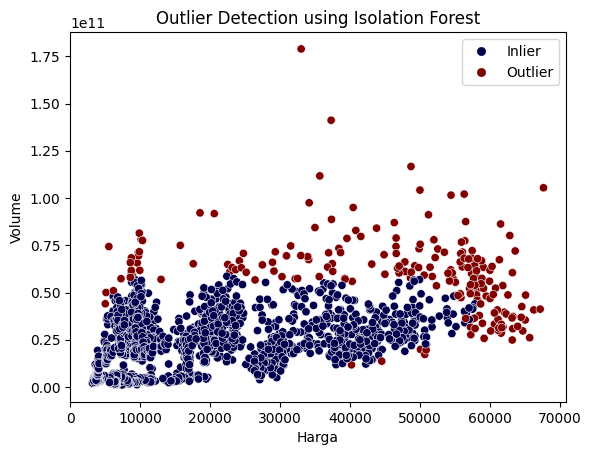

In [ ]:
# Scatter plot with colors based on the 'anomaly' column
scatter = plt.scatter(df['price'], df['volume'], c=df['anomaly'], cmap='seismic', edgecolors='white', linewidths=.4)

# Adding labels and title
plt.xlabel('Harga')
plt.ylabel('Volume')
plt.title('Outlier Detection using Isolation Forest')

# Create a legend using scatter object and its mapping
legend_labels = {0: 'Inlier', 1: 'Outlier'}
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels.values(), loc='upper right')

# Show the plot
plt.show()

Outlier Method: Isolation Forest
Number of anomalous values 204
Number of non anomalous values  1831
Total Number of Values: 2035



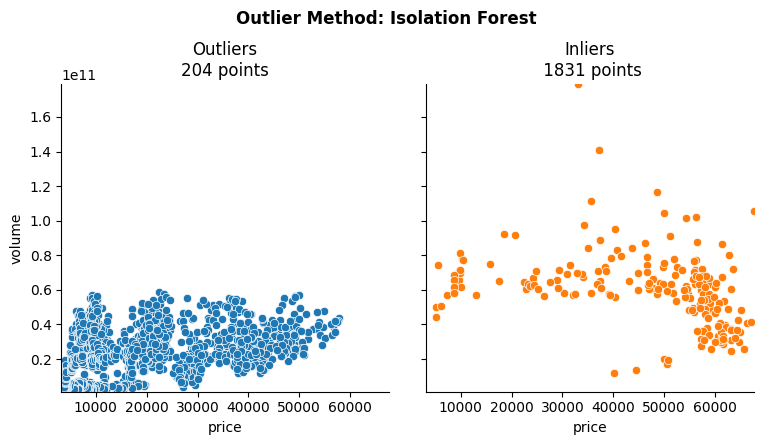

In [ ]:
outlier_plot(df, "Isolation Forest", 'price', 'volume', [df['price'].min(),df['price'].max()], [df['volume'].min(),df['volume'].max()])

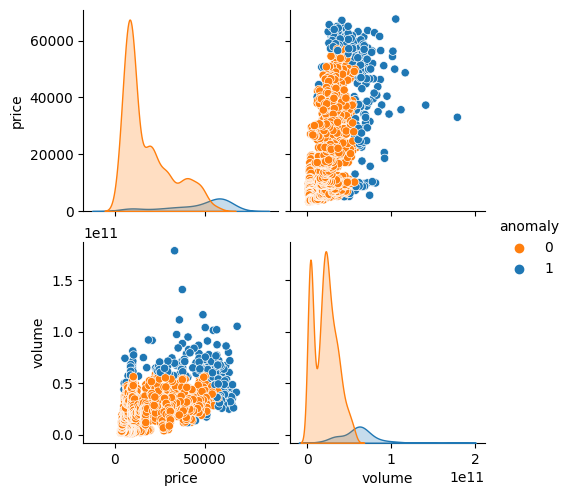

In [ ]:
palette = ['#ff7f0e', '#1f77b4']
anomaly_inputs = ['price', 'volume']
sns.pairplot(df, vars=anomaly_inputs, hue='anomaly', palette=palette)

#### Handling

In [ ]:
def moving_average(df, column, window = 24):
  i = 0
  res = []
  for i in np.arange(len(df.iloc[window:len(df)])):
    res.append(df[column].iloc[i:i+window].mean())
  return res

In [ ]:
import pandas as pd

# Set the mode to suppress the warning
pd.options.mode.chained_assignment = None  # or 'warn' to show the warning, or 'raise' to raise an exception

# Your code that generates the SettingWithCopyWarning

# Reset the mode to the default value if needed
# pd.options.mode.chained_assignment = 'warn'  # or 'raise' to revert to the default behavior

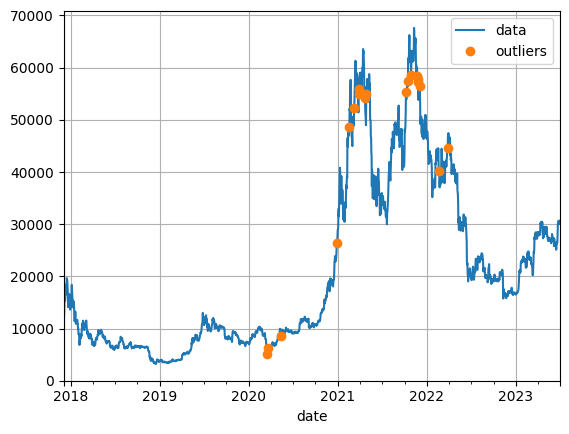

In [ ]:
dfAnomaly  = df[df['anomaly'] == 1]
dfAnomaly = dfAnomaly[dfAnomaly.index < df.iloc[int(len(df)*.8)].name].sort_values(by = 'anomaly_scores', ascending = False)
dfAnomaly = dfAnomaly.iloc[:int(len(dfAnomaly)*.1)]

df['price'].plot(label='data')
# avgPrice.plot(label='mean')
df.loc[dfAnomaly.index, 'price'].plot(label='outliers', marker='o', ls='')
plt.grid()
plt.legend()

In [ ]:
dfAnomaly

price        volume       sen      trend  anomaly_scores  \
date                                                                          
2020-12-28  26423.228792  5.665498e+10  0.074402  22.333269       -0.000037   
2021-04-28  54991.814843  4.846856e+10 -0.176085  21.021930       -0.000232   
2021-11-20  58459.255517  3.785126e+10 -0.081364  12.847350       -0.000635   
2022-02-20  40192.759121  1.173518e+10  0.167328  14.187445       -0.001406   
2021-11-25  57198.183846  3.169537e+10  0.655391  13.664808       -0.001667   
2020-03-17   5032.501351  4.403444e+10 -0.022829   9.686829       -0.001761   
2020-05-12   8604.751591  5.799608e+10 -0.104345  10.566071       -0.002458   
2021-03-27  55033.100480  5.544256e+10  0.017576  18.552525       -0.002866   
2022-03-27  44510.844218  1.367653e+10  0.080322  11.091825       -0.002909   
2021-03-09  52328.535913  5.356895e+10  0.063780  26.114012       -0.002938   
2021-03-28  55832.418110  4.728575e+10 -0.078684  17.292278       -0.003358   
2021-10-07  55415.005742  4.846239e+10  0.044664  16.117182       -0.003407   
2021-12-03  56508.268054  3.629634e+10  0.013238  12.029891       -0.003564   
2021-10-15  57452.431785  3.599460e+10  0.177133  21.839388       -0.004189   
2021-11-24  57748.793174  3.642119e+10  0.430263  16.117182       -0.004256   
2021-04-22  54190.070263  5.611537e+10  0.151460  27.561594       -0.005369   
2021-02-15  48607.874522  5.773838e+10  0.508385  29.264632       -0.005416   
2020-03-21   6195.603505  5.093677e+10  0.276109   7.488722       -0.005485   
2021-10-28  58641.001474  4.397625e+10  0.582955  16.117182       -0.005625   

            anomaly  
date                 
2020-12-28        1  
2021-04-28        1  
2021-11-20        1  
2022-02-20        1  
2021-11-25        1  
2020-03-17        1  
2020-05-12        1  
2021-03-27        1  
2022-03-27        1  
2021-03-09        1  
2021-03-28        1  
2021-10-07        1  
2021-12-03        1  
2021-10-15        1  
2021-11-24        1  
2021-04-22        1  
2021-02-15        1  
2020-03-21        1  
2021-10-28        1

In [ ]:
anMean = []
for i in np.arange(50):
  i+=1
  df = anomaly_search(df)
  df['anomaly'] = df['anomaly'].map({1:0, -1:1})
  dfAnomaly  = df[df['anomaly'] == 1]
  lenWin = i
  rollPrice  = moving_average(df, 'price' , lenWin)
  rollVolume = moving_average(df, 'volume', lenWin)

  df['repPrice']  = np.nan
  df['repVolume'] = np.nan
  df['repVolume'].iloc[lenWin:len(df)] = rollVolume
  df['repPrice'].iloc[lenWin:len(df)] = rollPrice

  dfAnomaly = dfAnomaly[dfAnomaly['anomaly_scores'] < -0.1]

  df2 = df.copy()
  df2.loc[dfAnomaly.index, 'price']  =  df2['repPrice'].loc[dfAnomaly.index].values
  df2.loc[dfAnomaly.index, 'volume'] = df2['repVolume'].loc[dfAnomaly.index].values

  df2 = anomaly_search(df2[['price', 'volume']])
  dfAnomaly  = df2[df2['anomaly'] == 1]
  anMean.append(dfAnomaly['anomaly_scores'].sum())

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names,

In [ ]:
iForest = pd.DataFrame()
iForest['window'] = np.arange(1, 51, 1)
iForest['anMean'] = anMean
iForest.set_index('window', inplace = True)

In [ ]:
iForest.sort_values(by = 'anMean', inplace = True)
iForest.head()
# iForest.to_csv('iForest_window.csv')

anMean
window            
8       167.061582
10      168.200033
2       168.218098
13      169.448956
15      169.626999

In [ ]:
dfPrice = df[['price']].copy()

In [ ]:
dfPrice.head()

price
date                    
2017-12-03  11256.701829
2017-12-04  11634.984955
2017-12-05  12174.253740
2017-12-06  13876.473579
2017-12-07  18491.181554

In [ ]:
df = anomaly_search(df)
df['anomaly'] = df['anomaly'].map({1:0, -1:1})
dfAnomaly  = df[df['anomaly'] == 1]

lenWin = 50

rollPrice  = moving_average(df, 'price' , lenWin)
rollVolume = moving_average(df, 'volume', lenWin)

df['repPrice']  = np.nan
df['repVolume'] = np.nan
df['repVolume'].iloc[lenWin:len(df)] = rollVolume
df['repPrice'].iloc[lenWin:len(df)] = rollPrice

dfAnomaly = dfAnomaly[dfAnomaly['anomaly_scores'] < -0.1]

df2 = df.copy()
df2.loc[dfAnomaly.index, 'price']  =  df2['repPrice'].loc[dfAnomaly.index].values
df2.loc[dfAnomaly.index, 'volume'] = df2['repVolume'].loc[dfAnomaly.index].values

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


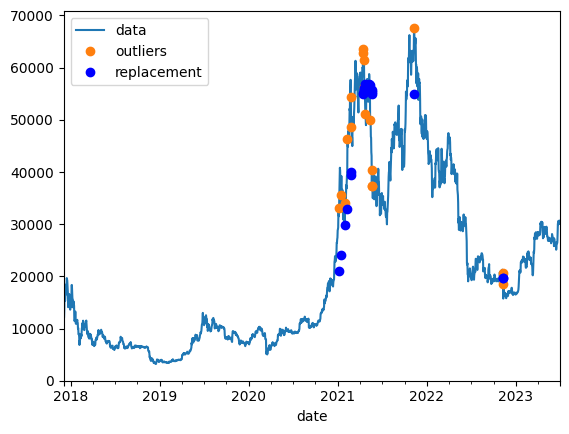

In [ ]:
df['price'].plot(label='data')
# avgPrice.plot(label='mean')
df.loc[dfAnomaly.index, 'price'].plot(label='outliers', marker='o', ls='')
df.loc[dfAnomaly.index, 'repPrice'].plot(label='replacement', marker='o', ls='', color = 'blue')
plt.legend()

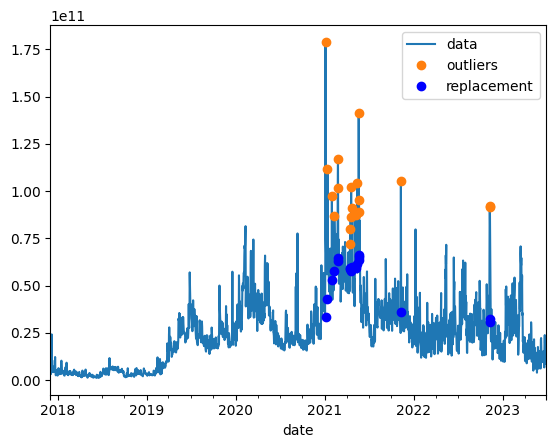

In [ ]:
df['volume'].plot(label='data')
# avgPrice.plot(label='mean')
df.loc[dfAnomaly.index, 'volume'].plot(label='outliers', marker='o', ls='')
df.loc[dfAnomaly.index, 'repVolume'].plot(label='replacement', marker='o', ls='', color = 'blue')
plt.legend()

In [ ]:
df2 = df.copy()
df2.loc[dfAnomaly.index, 'price']  =  df2['repPrice'].loc[dfAnomaly.index].values
df2.loc[dfAnomaly.index, 'volume'] = df2['repVolume'].loc[dfAnomaly.index].values

In [ ]:
df2

price        volume       sen      trend  week  day  month  \
date                                                                            
2017-12-03  11256.701829  5.761492e+09  0.012876  28.583750    48    3     12   
2017-12-04  11634.984955  3.216350e+09 -0.272631  32.723823    49    4     12   
2017-12-05  12174.253740  3.131953e+09 -0.065962  34.793859    49    5     12   
2017-12-06  13876.473579  5.086411e+09 -0.141230  46.179058    49    6     12   
2017-12-07  18491.181554  1.648292e+10 -0.169460  98.964982    49    7     12   
...                  ...           ...       ...        ...   ...  ...    ...   
2023-06-25  30537.816665  1.173612e+10 -0.307940   6.846403    25   25      6   
2023-06-26  30454.756974  1.207682e+10  0.074923   7.642420    26   26      6   
2023-06-27  30285.505064  1.603218e+10  0.193617   6.846403    26   27      6   
2023-06-28  30693.546356  1.441185e+10  0.210300   6.846403    26   28      6   
2023-06-29  30083.477245  8.489428e+09 -0.058915   6.581065    26   29      6   

            year  anomaly_scores  anomaly      repPrice     repVolume  
date                                                                   
2017-12-03  2017        0.081052        1           NaN           NaN  
2017-12-04  2017        0.066869        1           NaN           NaN  
2017-12-05  2017        0.047051        1           NaN           NaN  
2017-12-06  2017        0.046741        1           NaN           NaN  
2017-12-07  2017        0.099112        1           NaN           NaN  
...          ...             ...      ...           ...           ...  
2023-06-25  2023        0.051536        1  26966.671327  1.335516e+10  
2023-06-26  2023        0.052852        1  27103.852252  1.342745e+10  
2023-06-27  2023        0.075323        1  27255.129564  1.342415e+10  
2023-06-28  2023        0.061378        1  27381.703105  1.344932e+10  
2023-06-29  2023        0.028595        1  27532.835398  1.377176e+10  

[2035 rows x 12 columns]

In [ ]:
# df2.drop(columns=['week', 'day', 'month', 'year', 'anomaly_scores', 'anomaly'], inplace = True, axis = 1)
df2[['price', 'sen', 'volume', 'trend']].to_csv('dataClean10_8.csv')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Outlier Method: Isolation Forest
Number of anomalous values 204
Number of non anomalous values  1831
Total Number of Values: 2035



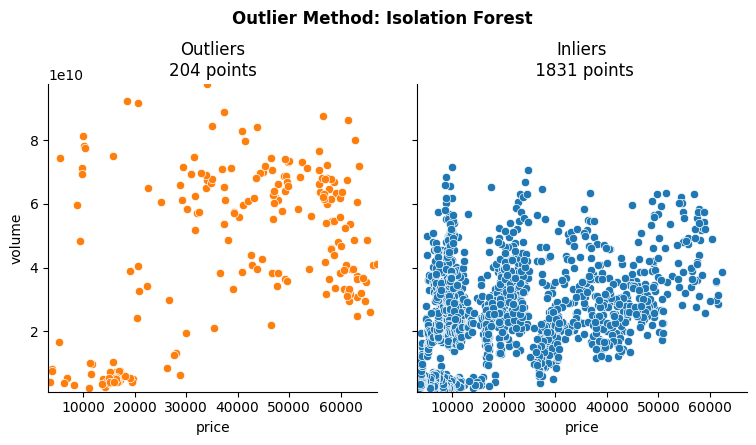

In [ ]:
df2 = anomaly_search(df2)
outlier_plot(df2, "Isolation Forest", 'price', 'volume', [df2['price'].min(),df2['price'].max()], [df2['volume'].min(),df2['volume'].max()])

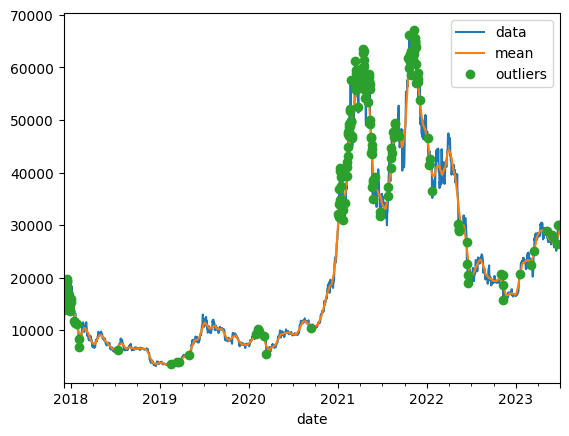

In [ ]:
dfAnomaly = df2[df2['anomaly'] == -1]

df2['price'].plot(label='data')
avgPrice.plot(label='mean')
df2.loc[dfAnomaly.index, 'price'].plot(label='outliers', marker='o', ls='')
# avg[dfAnomaly.index].plot(label='replacement', marker='o', ls='', color = 'blue')
plt.legend()
plt.show()

dfAnomaly = dfAnomaly[dfAnomaly['anomaly_scores'] < -0.1]

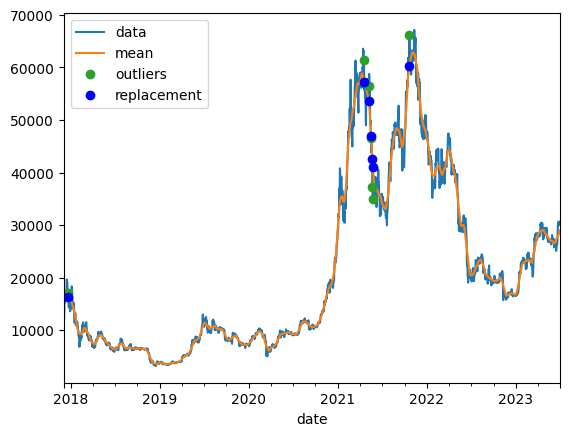

In [ ]:
df2['price'].plot(label='data')
avgPrice.plot(label='mean')
df2.loc[dfAnomaly.index, 'price'].plot(label='outliers', marker='o', ls='')
avgPrice[dfAnomaly.index].plot(label='replacement', marker='o', ls='', color = 'blue')
plt.legend()
plt.show()

## Final Result

In [ ]:
df2.drop(columns = ['anomaly_scores', 'anomaly'], axis = 1, inplace = True)
df2.to_csv("finalData2.csv")

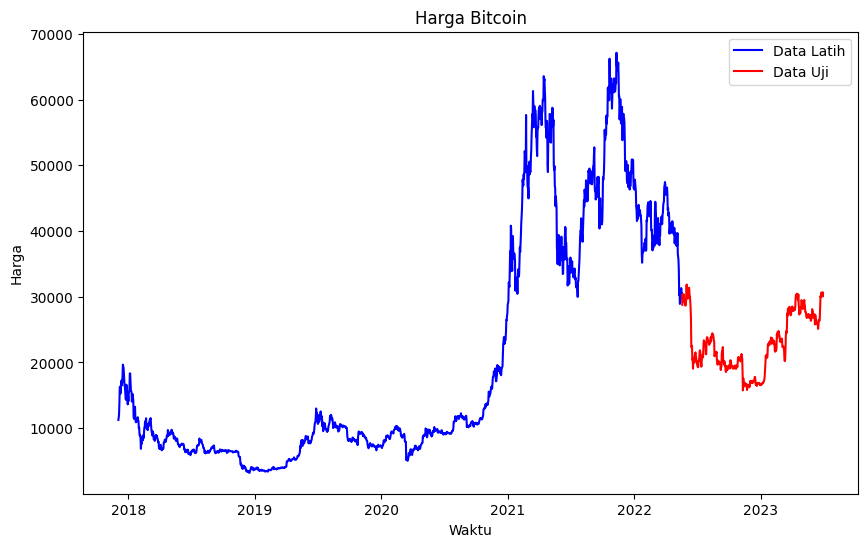

In [ ]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(df2, test_size=0.2, shuffle=False)

# Line plot for training and validation data
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['price'], label='Data Latih', color='blue')
plt.plot(val_data.index, val_data['price'], label='Data Uji', color='red')

plt.title('Harga Bitcoin')
plt.xlabel('Waktu')
plt.ylabel('Harga')
plt.legend()
plt.show()

# Experiment!

In [ ]:
dfSenCount2 = dfSen[dfSen['sen'] != 0]
dfSenCount2 = dfSenCount2.groupby('date').mean()
scaler = MinMaxScaler(feature_range=(-1, 1))
dfSenCount2['sen'] = scaler.fit_transform(dfSenCount2)

In [ ]:
# Create a date range covering the entire period
start_date = dfSenCount.index.min()
end_date = dfSenCount.index.max()
date_range = pd.date_range(start_date, end_date)

# Reindex the DataFrame to include missing dates
dfSenCount2 = dfSenCount2.reindex(date_range)

# Fill missing values with the mean of the surrounding data
dfSenCount2.interpolate(method = 'linear', inplace = True)
# dfSenCount2['sen'] = dfSenCount2['sen'].fillna((dfSenCount2['sen'].shift() + dfSenCount2['sen'].shift(-1)) / 2)

In [ ]:
df2 = pd.concat([dfPrice[['price', 'volume']], dfSenCount2, dfTrends], axis = 1)
df2.index.name = 'date'

### Outlier

In [ ]:
# # Create a figure with three subplots in a vertical layout
# fig, axes = plt.subplots(1, 4, figsize=(12, 4))

# for i, x in enumerate(['price', 'volume', 'sen', 'trend']):
#   axes[i].boxplot(df[x], vert=True)
#   axes[i].set_title(f'{x}')
#   axes[i].set_xticklabels([])

# fig.suptitle("Box Plot")
# plt.tight_layout()
# plt.show()

In [ ]:
dfScaled = transform(None, None)

In [ ]:
from sklearn.ensemble import IsolationForest
def anomaly_search(df):
  anomaly_inputs = ['price', 'volume', 'sen', 'trend']
  model_IF = IsolationForest(contamination=float(0.1),random_state=42069)
  model_IF.fit(df[anomaly_inputs])
  df['anomaly_scores'] = model_IF.decision_function(df[anomaly_inputs])
  df['anomaly'] = model_IF.predict(df[anomaly_inputs])
  return df

In [ ]:
def outlier_plot(data, outlier_method_name, x_var, y_var,
                 xaxis_limits=[0,1], yaxis_limits=[0,1]):

    print(f'Outlier Method: {outlier_method_name}')

    # Create a dynamic title based on the method
    method = f'{outlier_method_name}_anomaly'

    # Print out key statistics
    print(f"Number of anomalous values {len(data[data['anomaly']==-1])}")
    print(f"Number of non anomalous values  {len(data[data['anomaly']== 1])}")
    print(f'Total Number of Values: {len(data)}\n')

    # Create the chart using seaborn
    g = sns.FacetGrid(data, col='anomaly', height=4, hue='anomaly', hue_order=[1,-1])
    g.map(sns.scatterplot, x_var, y_var)
    g.fig.suptitle(f'Outlier Method: {outlier_method_name}', y=1.10, fontweight='bold')
    g.set(xlim=xaxis_limits, ylim=yaxis_limits)
    axes = g.axes.flatten()
    axes[0].set_title(f"Outliers\n{len(data[data['anomaly']== -1])} points")
    axes[1].set_title(f"Inliers\n {len(data[data['anomaly']==  1])} points")
    plt.show()
    return g

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Outlier Method: Isolation Forest
Number of anomalous values 204
Number of non anomalous values  1831
Total Number of Values: 2035



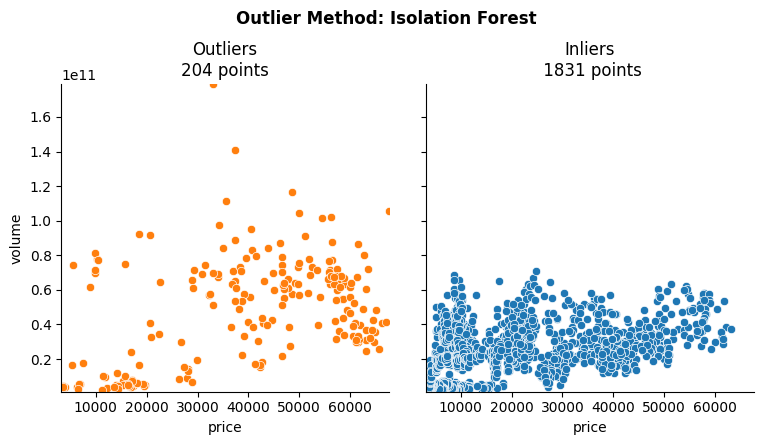

In [ ]:
df2 = anomaly_search(df2)
outlier_plot(df2, "Isolation Forest", 'price', 'volume', [df2['price'].min(),df2['price'].max()], [df2['volume'].min(),df2['volume'].max()])

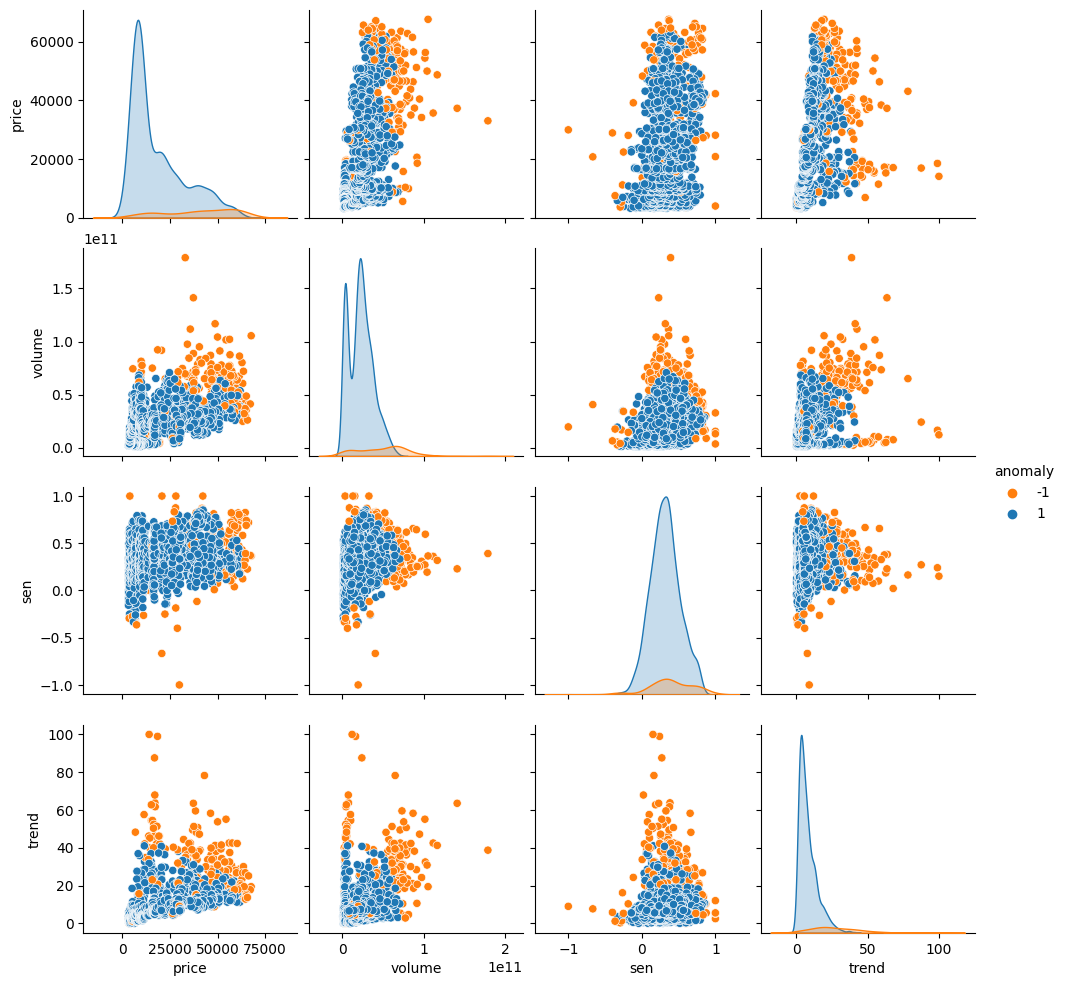

In [ ]:
palette = ['#ff7f0e', '#1f77b4']
anomaly_inputs = ['price', 'volume', 'sen', 'trend']
sns.pairplot(df2, vars=anomaly_inputs, hue='anomaly', palette=palette)

#### Handling

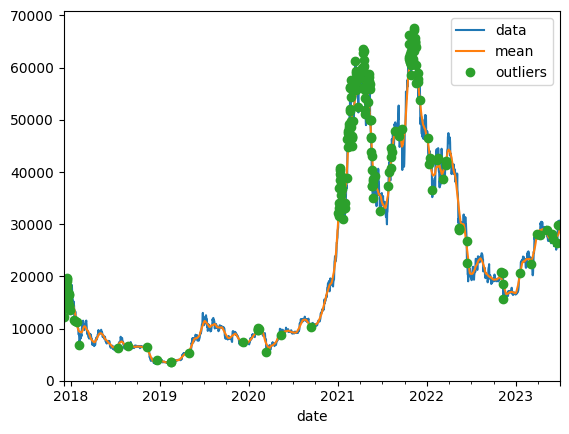

In [ ]:
dfAnomaly = df2[df2['anomaly'] == -1]
lenWin = 24

rollPrice  = df2['price'].rolling(window=lenWin, min_periods=1, center=True)
rollVolume = df2['volume'].rolling(window=lenWin, min_periods=1, center=True)
rollSen  = df2['sen'].rolling(window=lenWin, min_periods=1, center=True)
rollTrend = df2['trend'].rolling(window=lenWin, min_periods=1, center=True)
avgPrice  = rollPrice.mean()
avgVolume = rollVolume.mean()
avgSen = rollSen.mean()
avgTrend = rollTrend.mean()

df2['price'].plot(label='data')
avgPrice.plot(label='mean')
df2.loc[dfAnomaly.index, 'price'].plot(label='outliers', marker='o', ls='')
# avg[dfAnomaly.index].plot(label='replacement', marker='o', ls='', color = 'blue')
plt.legend()
plt.show()

dfAnomaly = dfAnomaly[dfAnomaly['anomaly_scores'] < -0.1]

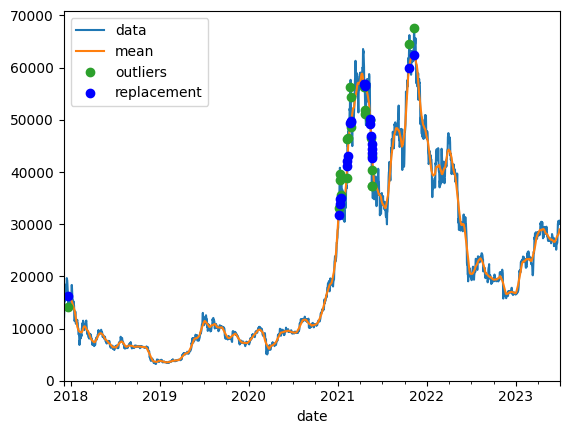

In [ ]:
df2['price'].plot(label='data')
avgPrice.plot(label='mean')
df2.loc[dfAnomaly.index, 'price'].plot(label='outliers', marker='o', ls='')
avgPrice[dfAnomaly.index].plot(label='replacement', marker='o', ls='', color = 'blue')
plt.legend()

In [ ]:
print(len(dfAnomaly))
print(len(df2[df2['anomaly'] == -1]))

23
204


In [ ]:
df2 = df2.copy()
df2.loc[dfAnomaly.index, 'price']  = avgPrice.loc[dfAnomaly.index].values
df2.loc[dfAnomaly.index, 'volume'] = avgVolume.loc[dfAnomaly.index].values
df2.loc[dfAnomaly.index, 'sen'] = avgSen.loc[dfAnomaly.index].values
df2.loc[dfAnomaly.index, 'trend'] = avgTrend.loc[dfAnomaly.index].values

In [ ]:
# df2.drop(columns=['week', 'day', 'month', 'year', 'anomaly_scores', 'anomaly'], inplace = True)
# df2.to_csv('finalData2.csv')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Outlier Method: Isolation Forest
Number of anomalous values 204
Number of non anomalous values  1831
Total Number of Values: 2035



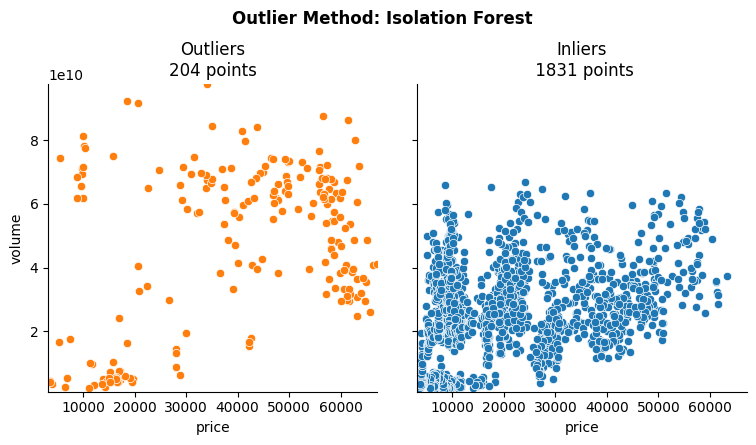

In [ ]:
df2 = anomaly_search(df2)
outlier_plot(df2, "Isolation Forest", 'price', 'volume', [df2['price'].min(),df2['price'].max()], [df2['volume'].min(),df2['volume'].max()])

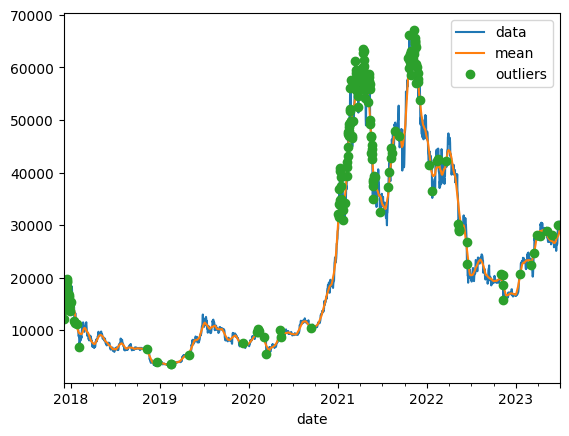

In [ ]:
dfAnomaly = df2[df2['anomaly'] == -1]

df2['price'].plot(label='data')
avgPrice.plot(label='mean')
df2.loc[dfAnomaly.index, 'price'].plot(label='outliers', marker='o', ls='')
# avg[dfAnomaly.index].plot(label='replacement', marker='o', ls='', color = 'blue')
plt.legend()
plt.show()

dfAnomaly = dfAnomaly[dfAnomaly['anomaly_scores'] < -0.1]

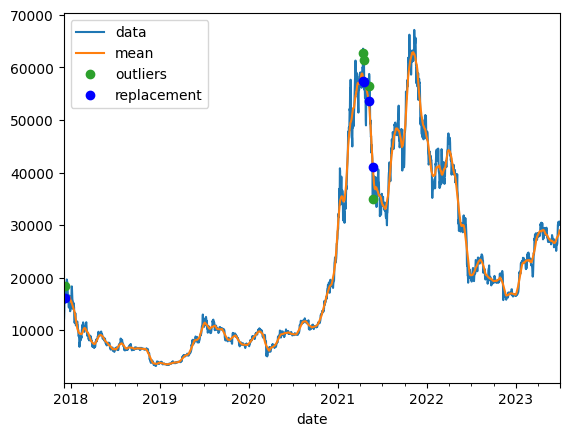

In [ ]:
df2['price'].plot(label='data')
avgPrice.plot(label='mean')
df2.loc[dfAnomaly.index, 'price'].plot(label='outliers', marker='o', ls='')
avgPrice[dfAnomaly.index].plot(label='replacement', marker='o', ls='', color = 'blue')
plt.legend()
plt.show()

In [ ]:
df2.drop(['anomaly_scores', 'anomaly'], axis = 1, inplace = True)
df2.to_csv('dataExperiment.csv')

In [ ]:
df2

price        volume       sen      trend
date                                                       
2017-12-03  11256.701829  5.761492e+09  0.401869  28.583750
2017-12-04  11634.984955  3.216350e+09  0.133333  32.723823
2017-12-05  12174.253740  3.131953e+09  0.486239  34.793859
2017-12-06  13876.473579  5.086411e+09  0.295039  46.179058
2017-12-07  18491.181554  1.648292e+10  0.240893  98.964982
...                  ...           ...       ...        ...
2023-06-25  30537.816665  1.173612e+10  0.066667   6.846403
2023-06-26  30454.756974  1.207682e+10  0.529412   7.642420
2023-06-27  30285.505064  1.603218e+10  0.560976   6.846403
2023-06-28  30693.546356  1.441185e+10  0.565217   6.846403
2023-06-29  30083.477245  8.489428e+09  0.333333   6.581065

[2035 rows x 4 columns]

## Feature Importance

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
%matplotlib inline

In [ ]:
X = df2.iloc[:,1:].reset_index(drop = True).copy()
estimators=[]
estimators.append(['minmax',MinMaxScaler(feature_range=(-1,1))])
scale=Pipeline(estimators)
X=scale.fit_transform(X)
pca = PCA(n_components=3,random_state=42069)
pca.fit(X)

In [ ]:
np.cumsum(pca.explained_variance_ratio_)

In [ ]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

print(f"\n{pca.explained_variance_ratio_}")

In [ ]:
df_pca=pd.DataFrame(pca.components_).transpose()
df_pca.columns=df2.iloc[:,1:].columns
y=df2.iloc[:,1:2]
y.reset_index(drop=True,inplace=True)
df_pca['priceUSD']=y
df_pca.head()

# Parameter Final

In [ ]:
DIR = "./Skripsi/gridSearchNLP/"

List = ['256GT', '256GTH', '256T',
        '128GT', '128GTH', '128T',
        '128_2GT', '128_2GTH', '128_2T',
        '256_2GT', '128_2GTH', '128_2T'
       ]

dfList = []
dfFinal = pd.DataFrame()
for i, x in enumerate(List):
    globals()[f'df{i}'] = pd.read_csv(DIR+f"result_{x}.csv")
    globals()[f'df{i}']['type'] = x
    del globals()[f'df{i}']['Unnamed: 0']
    globals()[f'df{i}'].reset_index(inplace = True, drop = True)
    dfFinal = pd.concat([dfFinal, globals()[f'df{i}']])
    dfList.append(globals()[f'df{i}'])

In [ ]:
dfFinal.reset_index(inplace = True, drop = True)
dfFinal.set_index('type', inplace = True)
dfTop = dfFinal.sort_values(by = 'testAccuracy', ascending = False).head(10)

In [ ]:
print(dfTop)
dfTop.to_csv('paramsSenFinale.csv')

          eval_loss  eval_acc  eval_runtime  eval_samples_per_second  \
type                                                                   
256T       0.855654  0.623333        0.4051                  740.508   
256T       0.839371  0.640000        0.3957                  758.062   
128_2T     0.868867  0.656667        0.4042                  742.202   
128_2T     0.868867  0.656667        0.4042                  742.202   
256GT      2.237333  0.600000        0.3819                  785.582   
128_2T     0.933704  0.643333        0.4014                  747.367   
128_2T     0.933704  0.643333        0.4014                  747.367   
128_2GTH   1.650386  0.653333        0.4268                  702.862   
128_2GTH   1.137640  0.626667        0.4141                  724.477   
128_2GT    1.977690  0.606667        0.4248                  706.183   

          eval_steps_per_second  epoch  time_this_iter_s  training_iteration  \
type                                                   

# Final Parameter

In [ ]:
dfC10.iloc[50]

in_len                       16
out_len                      28
d_model                      32
nhead                         8
num_encoder_layers            5
num_decoder_layers            3
dim_feedforward            1024
batch_size                   19
dropout                0.000443
lr                      0.00004
year                      False
sMAPE                 12.934295
sMAPE2                15.041622
MAPE                  14.083776
Name: 50, dtype: object

In [ ]:
dfC10.iloc[49]

in_len                       14
out_len                      29
d_model                      32
nhead                         8
num_encoder_layers            4
num_decoder_layers            2
dim_feedforward            1024
batch_size                   68
dropout                0.010038
lr                     0.000021
year                      False
sMAPE                 12.775561
sMAPE2                 12.35096
MAPE                  11.999947
Name: 49, dtype: object

In [ ]:
DIR = './Skripsi/gridSearchResult/Phase 2/'
dfExp = pd.read_csv(DIR + "resultExperiment.csv")
temp1 = pd.read_csv(DIR + "resultExperiment-1.csv")
temp2 = pd.read_csv(DIR + "resultExperiment-2.csv")
dfExp = pd.concat([dfExp, temp1, temp2])
dfExp.reset_index(inplace = True, drop = True)
print(len(dfExp))

60


In [ ]:
dfC10 = pd.read_csv(DIR + "resultClean10.csv")
temp = pd.read_csv(DIR + "resultClean10-1.csv")
dfC10 = pd.concat([dfC10, temp])
dfC10.reset_index(inplace = True, drop = True)
print(len(dfC10))

60


In [ ]:
dfRaw = pd.read_csv(DIR + "resultRaw.csv")
temp1 = pd.read_csv(DIR + "resultRaw-1.csv")
temp2 = pd.read_csv(DIR + "resultRaw-2.csv")
dfRaw = pd.concat([dfRaw, temp1, temp2])
dfRaw.reset_index(inplace = True, drop = True)
print(len(dfRaw))

60


In [ ]:
dfRaw.sort_values(by = 'sMAPE2').head()

in_len  out_len  d_model  nhead  num_encoder_layers  num_decoder_layers  \
56      18       27       32      8                   5                   5   
50      16       28       32      8                   5                   3   
41      16       29       32      8                   5                   2   
35      28       27       64      8                   8                   6   
6       28       18       64      2                   2                   6   

    dim_feedforward  batch_size   dropout        lr   year      sMAPE  \
56             1024          18  0.052258  0.000050   True  13.711979   
50             1024          19  0.000443  0.000040  False  12.934295   
41             1024          48  0.000922  0.000024  False   9.990416   
35              512          74  0.068205  0.000035  False  16.616163   
6               512         268  0.262650  0.000018   True  13.736819   

       sMAPE2       MAPE  
56   8.991903   9.184983  
50   9.489923   9.597617  
41  10.113193  10.573368  
35  11.013767  11.593569  
6   11.198297  11.364677

In [ ]:
dfC10.sort_values(by = 'sMAPE2').head()

in_len  out_len  d_model  nhead  num_encoder_layers  num_decoder_layers  \
56      18       27       32      8                   5                   5   
51      15       30       32      8                   4                   3   
40      16       26       32      8                   7                   4   
46      15       29       32      8                   4                   3   
45      12       29       32      8                   4                   2   

    dim_feedforward  batch_size   dropout        lr   year      sMAPE  \
56             1024          18  0.052258  0.000050   True  13.711979   
51             1024          19  0.000292  0.000015  False  12.985579   
40             1024          25  0.001963  0.000011   True   9.791919   
46             1024          26  0.002457  0.000017  False  11.968107   
45             1024          63  0.024519  0.000024  False  11.794256   

       sMAPE2       MAPE  
56   9.275537   9.017776  
51  10.742723  10.930853  
40  10.979947  11.323742  
46  11.590519  11.128027  
45  11.672709  11.527500

In [ ]:
dfExp.sort_values(by = 'sMAPE2').head()

in_len  out_len  d_model  nhead  num_encoder_layers  num_decoder_layers  \
35      28       27       64      8                   8                   6   
40      16       26       32      8                   7                   4   
51      15       30       32      8                   4                   3   
46      15       29       32      8                   4                   3   
49      14       29       32      8                   4                   2   

    dim_feedforward  batch_size   dropout        lr   year      sMAPE  \
35              512          74  0.068205  0.000035  False  16.616163   
40             1024          25  0.001963  0.000011   True   9.791919   
51             1024          19  0.000292  0.000015  False  12.985579   
46             1024          26  0.002457  0.000017  False  11.968107   
49             1024          68  0.010038  0.000021  False  12.775561   

       sMAPE2       MAPE  
35   9.356730   9.307969  
40   9.791919  10.131750  
51  10.509704  10.678764  
46  10.798632  11.422588  
49  10.935647  11.034981

# Trendy Analysis

In [ ]:
!git clone https://github.com/joaofig/pyloess

Cloning into 'pyloess'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 209 (delta 51), reused 34 (delta 18), pack-reused 127
Receiving objects: 100% (209/209), 415.67 KiB | 2.11 MiB/s, done.
Resolving deltas: 100% (110/110), done.


In [ ]:
import sys
sys.path.append('./pyloess/pyloess/')

# Now you can import modules from the specified directory
from Loess import Loess

In [ ]:
loess = Loess(df['sen'], np.arange(len(df['sen'])))

for x in df['sen']:
    y = loess.estimate(x, window=365, use_matrix=False, degree=1)

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess

/usr/local/lib/python3.10/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: divide by zero encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/usr/local/lib/python3.10/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/usr/local/lib/python3.10/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in multiply
  res, _ = _lowess(y, x, x, np.ones_like(x),


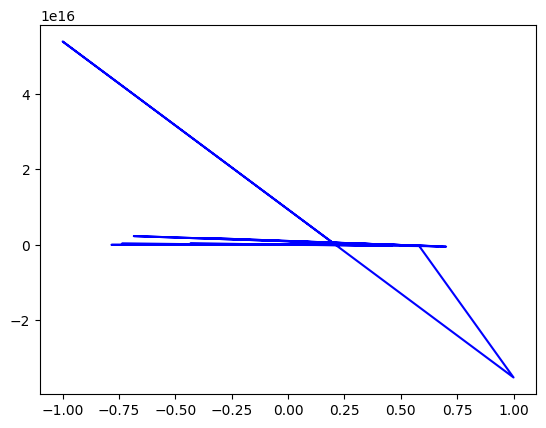

In [ ]:
filtered = lowess(np.arange(len(df['sen'])), df['sen'], is_sorted=True, frac=.9, it=14)

# plt.plot(df.index, np.arange(len(df['sen'])), 'r')
plt.plot(filtered[:,0], filtered[:,1], 'b')

plt.show()

In [ ]:
xx = np.array([0.5578196, 2.0217271, 2.5773252, 3.4140288, 4.3014084,
                4.7448394, 5.1073781, 6.5411662, 6.7216176, 7.2600583,
                8.1335874, 9.1224379, 11.9296663, 12.3797674, 13.2728619,
                4.2767453, 15.3731026, 15.6476637, 18.5605355, 18.5866354,
                18.7572812])
yy = np.array([18.63654, 103.49646, 150.35391, 190.51031, 208.70115,
                213.71135, 228.49353, 233.55387, 234.55054, 223.89225,
                227.68339, 223.91982, 168.01999, 164.95750, 152.61107,
                160.78742, 168.55567, 152.42658, 221.70702, 222.69040,
                243.18828])

loess = Loess(xx, yy)

for x in xx:
    y = loess.estimate(x, window=7, use_matrix=False, degree=1)
    print(x, y)

0.5578196 20.59302336641739
2.0217271 107.16030718700277
2.5773252 139.76738119024935
3.4140288 174.26304345983618
4.3014084 207.23338254894722
4.7448394 216.66158601444587
5.1073781 220.54447983405393
6.5411662 229.8606930091983
6.7216176 229.83471299994636
7.2600583 229.43011582669962
8.1335874 226.60445903778322
9.1224379 220.39040988503135
11.9296663 172.13730604017695
12.3797674 164.837577891528
13.2728619 150.35844781055118
4.2767453 172.4406622016163
15.3731026 171.5003290383674
15.6476637 176.00311128782405
18.5605355 224.44619242607277
18.5866354 224.88710059518593
18.7572812 227.77338194698612


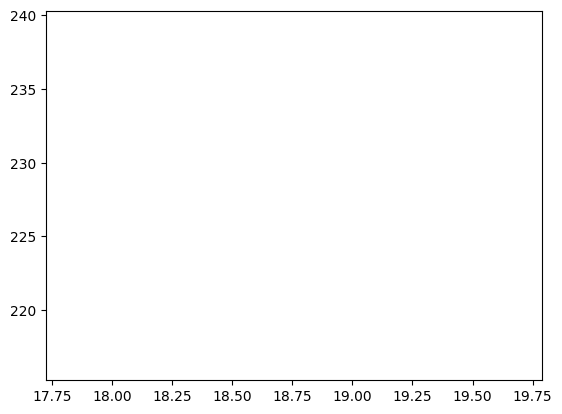

In [ ]:
plt.plot(x, y)

In [ ]:
from loess.loess_1d import loess_1d

In [ ]:
xout, yout, wout = loess_1d(df['sen'], np.arange(len(df['sen'])), xnew=None, degree=7, frac=0.9)

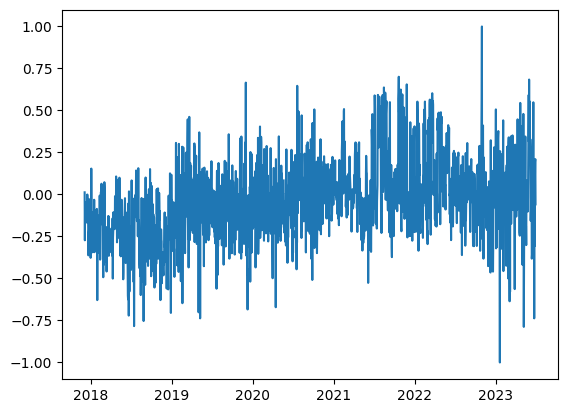

In [ ]:
plt.plot(xout)

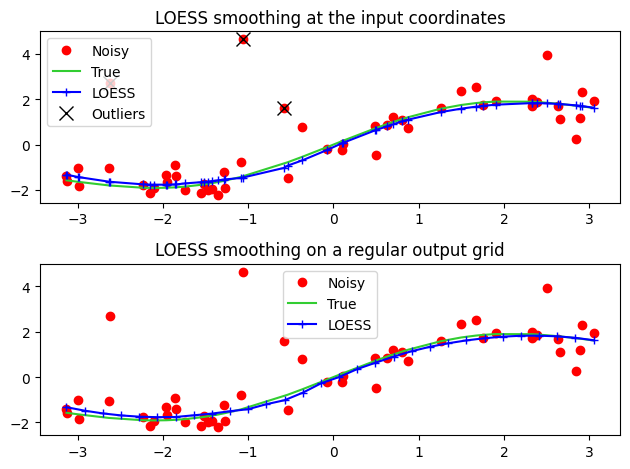

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from loess.loess_1d import loess_1d

def loess_1d_example():
    """ Usage example for loess_1d """

    n = 50
    nbad = int(n*0.1) # 10% outliers
    np.random.seed(5)

    # Compute the true model
    xtrue = np.random.uniform(-np.pi, np.pi, n - nbad)
    xtrue.sort()   # Sort only for plotting smooth lines
    ytrue = np.sin(xtrue) + xtrue/2

    # Add noise to the data
    sigy = 0.5
    yran = np.random.normal(ytrue, sigy)

    # Add outliers to the data
    xbad = np.random.uniform(-np.pi, np.pi, nbad)
    ybad = np.random.uniform(-5, 5, nbad)
    xfit = np.append(xtrue, xbad)
    yfit = np.append(yran, ybad)

    # Sort only for plotting smooth lines
    j = np.argsort(xfit)
    xfit, yfit = xfit[j], yfit[j]

    # LOESS smoothing on the same coordinates as input
    xout1, yout1, weights1 = loess_1d(xfit, yfit, frac=0.8, degree=2)

    # LOESS smoothing on a new output grid (xnew)
    xnew = np.linspace(np.min(xfit), np.max(xfit), 30)
    xout2, yout2, weights2 = loess_1d(xfit, yfit, xnew, frac=0.8, degree=2)

    plt.clf()
    plt.subplot(211)
    plt.plot(xfit, yfit, 'ro', label='Noisy')
    plt.plot(xtrue, ytrue, color='limegreen', label='True')
    plt.plot(xout1, yout1, '+-b', label='LOESS')
    w = weights1 < 0.34  # identify outliers
    plt.plot(xfit[w], yfit[w], 'xk', ms=10, label='Outliers')
    plt.title("LOESS smoothing at the input coordinates")
    plt.legend()

    plt.subplot(212)
    plt.plot(xfit, yfit, 'ro', label='Noisy')
    plt.plot(xtrue, ytrue, color='limegreen', label='True')
    plt.plot(xout2, yout2, '+-b', label='LOESS')
    plt.title("LOESS smoothing on a regular output grid")
    plt.legend()

    plt.tight_layout()
    plt.pause(1)

#-----------------------------------------------------------------------------

if __name__ == '__main__':

    loess_1d_example()


In [ ]:
df = pd.read_csv("./Skripsi/finalData/dataRaw.csv", index_col = ['date'], parse_dates = ['date'])

In [ ]:
from statsmodels.tsa.seasonal import MSTL
stl_kwargs = {"seasonal_deg": 0}

model = MSTL(df['sen'], periods=(365), stl_kwargs=stl_kwargs)
res = model.fit()

df['trendSmooth'] = res.trend

In [ ]:
df['sen'] = df['trendSmooth'].copy()
df.drop('sen', axis = 1, inplace = True)
df.to_csv("dataExperiment.csv")

In [ ]:
from statsmodels.tsa.seasonal import MSTL
stl_kwargs = {"seasonal_deg": 0}

model = MSTL(df['price'], periods=(365), stl_kwargs=stl_kwargs)
res = model.fit()

df['priceSmooth'] = res.trend

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit_transform(df[['trendSmooth']])
senScaled = scaler.transform(df[['trendSmooth']])

scaler.fit_transform(df[['priceSmooth']])
priceScaled = scaler.transform(df[['priceSmooth']])

In [ ]:
dfPlot = pd.DataFrame(index = df.index)
dfPlot["senScaled"] = senScaled
dfPlot["priceScaled"] = priceScaled

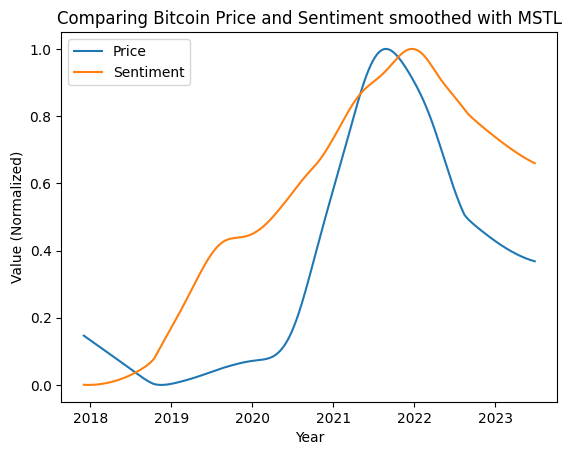

In [ ]:
# plt.plot(senScaled)
plt.plot(dfPlot["priceScaled"], label = 'Price')
plt.plot(dfPlot["senScaled"], label = 'Sentiment')
plt.title('Comparing Bitcoin Price and Sentiment smoothed with MSTL')
plt.xlabel("Year")
plt.ylabel("Value (Normalized)")
plt.legend()
plt.show()

In [ ]:
df

price        volume       sen      trend    senAvg
date                                                                 
2017-12-03  11256.701829  5.761492e+09  0.012876  28.583750       NaN
2017-12-04  11634.984955  3.216350e+09 -0.272631  32.723823       NaN
2017-12-05  12174.253740  3.131953e+09 -0.065962  34.793859       NaN
2017-12-06  13876.473579  5.086411e+09 -0.141230  46.179058       NaN
2017-12-07  18491.181554  1.648292e+10 -0.169460  98.964982       NaN
...                  ...           ...       ...        ...       ...
2023-06-25  30537.816665  1.173612e+10 -0.307940   6.846403  0.012323
2023-06-26  30454.756974  1.207682e+10  0.074923   7.642420  0.011817
2023-06-27  30285.505064  1.603218e+10  0.193617   6.846403  0.012252
2023-06-28  30693.546356  1.441185e+10  0.210300   6.846403  0.012276
2023-06-29  30083.477245  8.489428e+09 -0.058915   6.581065  0.011437

[2035 rows x 5 columns]

# Data Augmentation Again

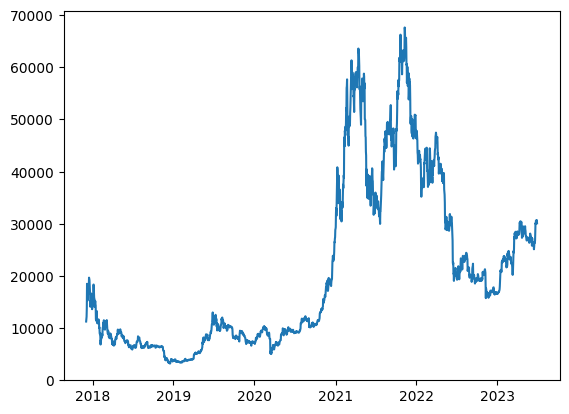

In [ ]:
plt.plot(df['price'])

In [ ]:
percentile25 = df['price'].quantile(0.25)
percentile75 = df['price'].quantile(0.75)

print(percentile25)
print(percentile75)

8104.728892496541
30308.484697222542


In [ ]:
df['price'].describe()

count     2035.000000
mean     20726.269138
std      16227.790009
min       3216.627150
25%       8104.728892
50%      13106.046019
75%      30308.484697
max      67617.015545
Name: price, dtype: float64

In [ ]:
outlier_treatment(df['price'])

(-25200.90481459246, 63614.11840431154)

# Oke Fix Final

In [ ]:
import pandas as pd
!rm -r "./Skripsi"
!git clone https://github.com/AfterRain007/Skripsi

rm: cannot remove './Skripsi': No such file or directory
Cloning into 'Skripsi'...
remote: Enumerating objects: 1281, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 1281 (delta 79), reused 181 (delta 76), pack-reused 1093
Receiving objects: 100% (1281/1281), 117.71 MiB | 11.74 MiB/s, done.
Resolving deltas: 100% (503/503), done.
Updating files: 100% (588/588), done.


In [ ]:
var1 = ['del',
        'only']

var2 = ['Trend',
        'Vol',
        'Sen']

result = pd.DataFrame()

sortBy = 'MAPE'

for x in var1:
  for y in var2:
    temp = pd.read_csv(f"./Skripsi/gridSearchResult/dfResultClean10TFT_{x}{y}.csv")
    temp.sort_values(by = sortBy, inplace = True)
    temp['Included Covariate'] = x + y
    temp.set_index('Included Covariate', inplace = True)
    result = pd.concat([result, temp.head(1)])

temp = pd.read_csv('./Skripsi/gridSearchResult/dfResultClean10TFT_onlyPrice.csv')
temp.sort_values(by = sortBy, inplace = True)
temp['Included Covariate'] = 'onlyPrice'
temp.set_index('Included Covariate', inplace = True)
result = pd.concat([result, temp.head(1)])

temp = pd.read_csv('./Skripsi/gridSearchResult/dfResultClean10TFT.csv')
temp.sort_values(by = sortBy, inplace = True)
temp['Included Covariate'] = 'Complete'
temp.set_index('Included Covariate', inplace = True)
result = pd.concat([result, temp.head(1)])
result.sort_index(inplace = True)
# result.sort_values(by = 'RMSE', inplace = True)

new_index_names = {'Complete': 'Trend, Sentiment, and Volume',
                   'delSen': 'Trend and Volume',
                   'delTrend': 'Sentiment and Volume',
                   'delVol': 'Trend and Sentiment',
                   'onlySen': 'Sentiment',
                   'onlyTrend': 'Trend',
                   'onlyVol': 'Volume',
                   'onlyPrice': 'Price'
                   }

result = result.rename(index=new_index_names)

In [ ]:
result.head(1)

in_len  out_len  hidden_size  lstm_layers  \
Included Covariate                                                        
Trend, Sentiment, and Volume      27       28            8            2   

                              num_attention_heads   dropout  \
Included Covariate                                            
Trend, Sentiment, and Volume                    6  0.184436   

                              hidden_continuous_size  use_static_covariates  \
Included Covariate                                                            
Trend, Sentiment, and Volume                       9                  False   

                              batch_size        lr      RMSE     sMAPE  \
Included Covariate                                                       
Trend, Sentiment, and Volume         128  0.001059  0.026366  3.102716   

                                  MAPE  
Included Covariate                      
Trend, Sentiment, and Volume  3.137002

In [ ]:
result[['RMSE', 'sMAPE', 'MAPE']].sort_values(by = 'RMSE')

RMSE     sMAPE      MAPE
Included Covariate                                        
Trend and Sentiment           0.026174  3.090021  3.128374
Trend and Volume              0.026299  3.113699  3.148417
Trend, Sentiment, and Volume  0.026366  3.102716  3.137002
Trend                         0.026466  3.112063  3.134724
Volume                        0.026508  3.101709  3.129670
Price                         0.026521  3.112355  3.144031
Sentiment                     0.026580  3.090768  3.120422
Sentiment and Volume          0.026604  3.106766  3.139589

In [ ]:
result[['RMSE', 'sMAPE', 'MAPE']]

RMSE     sMAPE      MAPE
Included Covariate                                        
Trend, Sentiment, and Volume  0.026366  3.102716  3.137002
Trend and Volume              0.026629  3.105957  3.153246
Sentiment and Volume          0.026633  3.104560  3.140440
Trend and Sentiment           0.026112  3.089147  3.128475
Price                         0.026521  3.112355  3.144031
Sentiment                     0.026580  3.090768  3.120422
Trend                         0.026405  3.109872  3.138121
Volumen                       0.026508  3.101709  3.129670

In [ ]:
result[['RMSE', 'sMAPE', 'MAPE']]

RMSE     sMAPE      MAPE
Included Covariate                                        
Trend, Sentiment, and Volume  0.026366  3.102716  3.137002
Trend and Volume              0.026299  3.113699  3.148417
Sentiment and Volume          0.026604  3.106766  3.139589
Trend and Sentiment           0.026174  3.090021  3.128374
Price                         0.026521  3.112355  3.144031
Sentiment                     0.026580  3.090768  3.120422
Trend                         0.026466  3.112063  3.134724
Volumen                       0.026508  3.101709  3.129670

# Some other finale idk im out of words

In [ ]:
dfResult = pd.DataFrame()
data = ['30', 'MAnP']
model = ['TFT', 'LSTM', 'TCN', 'GRU']

for x in data:
  for y in model:
    temp = pd.read_csv(f"./Skripsi/evalTS Diff4/result{y}_{x}.csv")
    temp.sort_values(by = 'RMSE', inplace = True)
    temp['type'] = y+x
    dfResult = pd.concat([dfResult, temp.head(3)])

dfResult.set_index('type', inplace = True)

In [ ]:
dfResult.sort_values(by = "RMSE")[['RMSE', "MAE", "MAPE"]].to_excel("resultDiff4MA.xlsx")

In [ ]:
dfResult.sort_values(by = "RMSE")

Unnamed: 0  in_len  out_len  hidden_size  lstm_layers  \
type                                                              
TFT30             26    28.0     24.0         13.0          2.0   
TCN30             86    13.0     11.0          NaN          NaN   
TCN30             81    15.0     11.0          NaN          NaN   
TCN30             50    14.0     11.0          NaN          NaN   
TFT30             40    31.0     29.0         28.0          3.0   
LSTMMAnP          42     NaN      NaN          NaN          NaN   
LSTMMAnP          43     NaN      NaN          NaN          NaN   
GRUMAnP           92     NaN      NaN          NaN          NaN   
GRUMAnP           93     NaN      NaN          NaN          NaN   
GRUMAnP           94     NaN      NaN          NaN          NaN   
LSTMMAnP          36     NaN      NaN          NaN          NaN   
LSTM30            38     NaN      NaN          NaN          NaN   
TCNMAnP           88     2.0      1.0          NaN          NaN   
TFTMAnP           90    26.0     19.0         24.0          2.0   
TFTMAnP           64    25.0     31.0         10.0          2.0   
LSTM30            45     NaN      NaN          NaN          NaN   
TCNMAnP           73     5.0      2.0          NaN          NaN   
TCNMAnP           65     5.0      2.0          NaN          NaN   
TFTMAnP           51    19.0     26.0          8.0          2.0   
LSTM30            91     NaN      NaN          NaN          NaN   
GRU30             98     NaN      NaN          NaN          NaN   
GRU30             43     NaN      NaN          NaN          NaN   
GRU30             95     NaN      NaN          NaN          NaN   
TFT30             46    17.0     31.0         24.0          3.0   

          num_attention_heads   dropout  hidden_continuous_size  batch_size  \
type                                                                          
TFT30                     3.0  0.164177                     7.0          32   
TCN30                     NaN  0.272155                     NaN          32   
TCN30                     NaN  0.282040                     NaN          32   
TCN30                     NaN  0.284699                     NaN          32   
TFT30                     7.0  0.265499                     9.0         128   
LSTMMAnP                  NaN  0.045367                     NaN         128   
LSTMMAnP                  NaN  0.024779                     NaN         128   
GRUMAnP                   NaN  0.042617                     NaN         256   
GRUMAnP                   NaN  0.041934                     NaN         256   
GRUMAnP                   NaN  0.041954                     NaN         256   
LSTMMAnP                  NaN  0.077168                     NaN         128   
LSTM30                    NaN  0.150270                     NaN         256   
TCNMAnP                   NaN  0.097168                     NaN         256   
TFTMAnP                   8.0  0.167162                     7.0         256   
TFTMAnP                   8.0  0.260019                     8.0         128   
LSTM30                    NaN  0.133021                     NaN         256   
TCNMAnP                   NaN  0.103839                     NaN         256   
TCNMAnP                   NaN  0.292102                     NaN          64   
TFTMAnP                   7.0  0.237021                     8.0         128   
LSTM30                    NaN  0.142452                     NaN         256   
GRU30                     NaN  0.079035                     NaN         256   
GRU30                     NaN  0.275012                     NaN         256   
GRU30                     NaN  0.060338                     NaN         256   
TFT30                     7.0  0.297996                     9.0         128   

         full_attention  ...      MAPE  input_chunk_length  training_length  \
type                     ...                                                  
TFT30             False  ...  3.059739                

In [ ]:
dfResult = pd.DataFrame()
data = ['BP', 'BPnP']
model = ['TFT', 'LSTM', 'TCN', 'GRU']

for x in data:
  for y in model:
    temp = pd.read_csv(f"./Skripsi/evalTS Diff4/result{y}_{x}.csv")
    temp.sort_values(by = 'RMSE', inplace = True)
    temp['type'] = y+x
    dfResult = pd.concat([dfResult, temp.head(1)])

# y = 'TFT'
# x = 'MAonlyTrend'
# temp = pd.read_csv(f"./Skripsi/evalTS Diff4/result{y}_{x}.csv")
# temp.sort_values(by = 'RMSE', inplace = True)
# temp['type'] = y+x
# dfResult = pd.concat([dfResult, temp.head(1)])

# x = 'MAexperiment'
# temp = pd.read_csv(f"./Skripsi/evalTS Diff4/result{y}_{x}.csv")
# temp.sort_values(by = 'RMSE', inplace = True)
# temp['type'] = y+x
# dfResult = pd.concat([dfResult, temp.head(1)])

# x = '30WOCovariates'
# temp = pd.read_csv(f"./Skripsi/evalTS Diff4/result{y}_{x}.csv")
# temp.sort_values(by = 'RMSE', inplace = True)
# temp['type'] = y+x
# dfResult = pd.concat([dfResult, temp.head(1)])

# x = '30WOAnyCovariates'
# temp = pd.read_csv(f"./Skripsi/evalTS Diff4/result{y}_{x}.csv")
# temp.sort_values(by = 'RMSE', inplace = True)
# temp['type'] = y+x
# dfResult = pd.concat([dfResult, temp.head(1)])

dfResult.set_index('type', inplace = True)

In [ ]:
dfResult.sort_values(by = "RMSE")[['RMSE', "MAE", "MAPE"]].to_excel("resultDiff4BP.xlsx")

In [ ]:
dfResult = pd.DataFrame()
y = 'TFT'
x = 'MAonlyTrend'
temp = pd.read_csv(f"./Skripsi/evalTS Diff4/result{y}_{x}.csv")
temp.sort_values(by = 'RMSE', inplace = True)
temp['type'] = y+x
dfResult = pd.concat([dfResult, temp.head(1)])

x = 'MAexperiment'
temp = pd.read_csv(f"./Skripsi/evalTS Diff4/result{y}_{x}.csv")
temp.sort_values(by = 'RMSE', inplace = True)
temp['type'] = y+x
dfResult = pd.concat([dfResult, temp.head(1)])

x = '30WOCovariates'
temp = pd.read_csv(f"./Skripsi/evalTS Diff4/result{y}_{x}.csv")
temp.sort_values(by = 'RMSE', inplace = True)
temp['type'] = y+x
dfResult = pd.concat([dfResult, temp.head(1)])

x = '30WOAnyCovariates'
temp = pd.read_csv(f"./Skripsi/evalTS Diff4/result{y}_{x}.csv")
temp.sort_values(by = 'RMSE', inplace = True)
temp['type'] = y+x
dfResult = pd.concat([dfResult, temp.head(1)])

dfResult.set_index('type', inplace = True)

In [ ]:
dfResult.sort_values(by = "RMSE")[['RMSE', "MAE", "MAPE"]].to_excel("resultDiff4Experiment.xlsx")

In [ ]:
timeTFT = pd.read_excel(f"./Skripsi/evalTS Diff4/timeTFT.xlsx")

In [ ]:
timeTFT

Unnamed: 0             0  Unnamed: 2
0         0.0  23891.370071         NaN
1         1.0  19708.407949         NaN
2         2.0  17354.649315         NaN
3         3.0  17345.145596         NaN
4         4.0  20378.069407         NaN
5         5.0  18680.734759         NaN
6         NaN  19559.729516  195.597295

In [ ]:
df = pd.read_excel("./Skripsi/backTestResult.xlsx")

In [ ]:
dfResult[:13][['RMSE', "MAE", "MAPE"]]

RMSE       MAE      MAPE
data                              
MA    0.026072  0.017704  3.097297
MA    0.026121  0.017513  3.052722
MA    0.026124  0.017776  3.110798
MA    0.026131  0.017458  3.044265
MA    0.026137  0.017805  3.116297
MAnP  0.026328  0.017559  3.073656
MAnP  0.026346  0.017542  3.061240
MAnP  0.026389  0.017539  3.076078
MAnP  0.026417  0.017440  3.047377
MAnP  0.026417  0.017435  3.050383
BP    0.046313  0.031195  6.725681
BP    0.047043  0.031684  6.836594
BP    0.047274  0.031850  6.984546

In [ ]:
dfResult = pd.DataFrame()
dfName = ["MA", "MAnP", "BP", "BPnP", "MAexperiment", "MAonlyTrend"]

for i, x in enumerate(dfName):
    temp = pd.read_csv(f"./Skripsi/resultTFT_{x}.csv")
    temp['data'] = x
    temp.set_index("data", inplace = True)
    temp.sort_values(by = 'RMSE', inplace = True)
    dfResult = pd.concat([dfResult, temp.head(5)])

dfResult.drop(["Unnamed: 0", 'type'], axis = 1, inplace = True)
# dfResult.sort_values(by = 'RMSE', inplace = True)
len(dfResult)

30

In [ ]:
dfResult = pd.read_csv(f"./Skripsi/resultTFT_MAexperiment.csv")

In [ ]:
dfResult.sort_values(by = 'RMSE')

Unnamed: 0  in_len  out_len  hidden_size  lstm_layers  \
68          68      15        7           14            1   
58          58       7        5           12            1   
14          14       7       15           14            3   
64          64      11        7           14            1   
2            2      10        1            9            1   
..         ...     ...      ...          ...          ...   
13          13       9        4           24            1   
6            6       3       27           16            1   
10          10      10        1           28            1   
36          36      14       31           30            1   
15          15      14       14           13            3   

    num_attention_heads   dropout  hidden_continuous_size  batch_size  \
68                    4  0.272618                       6         128   
58                    3  0.245608                       9         128   
14                    6  0.215987                       9          64   
64                    2  0.270435                      10         128   
2                     7  0.225051                       8         128   
..                  ...       ...                     ...         ...   
13                    6  0.112093                       7         256   
6                     7  0.042343                      10          32   
10                    2  0.295187                       7         128   
36                    6  0.238796                       8          32   
15                    6  0.122663                       7          64   

    full_attention        lr      RMSE       MAE      MAPE  
68            True  0.004554  0.025954  0.017430  3.048212  
58            True  0.004652  0.025996  0.017495  3.036545  
14            True  0.001105  0.026033  0.017593  3.077534  
64            True  0.004797  0.026069  0.017451  3.044623  
2             True  0.002814  0.026077  0.017406  3.045624  
..             ...       ...       ...       ...       ...  
13           False  0.003064  0.036703  0.029677  5.073284  
6             True  0.004887  0.036801  0.022777  4.022478  
10            True  0.002568  0.037922  0.031880  5.663636  
36            True  0.003244  0.044131  0.032632  5.593900  
15            True  0.001197  0.047049  0.039007  6.650631  

[100 rows x 14 columns]

In [ ]:
dfRaw = pd.read_csv("./Skripsi/finalData/dataRaw.csv", usecols=['date', 'sen'], parse_dates=['date'], index_col=['date'])
dfExperiment = pd.read_csv("./Skripsi/finalData/dataExperiment2.csv", usecols=['date', 'trendSmooth'], parse_dates=['date'], index_col=['date'])

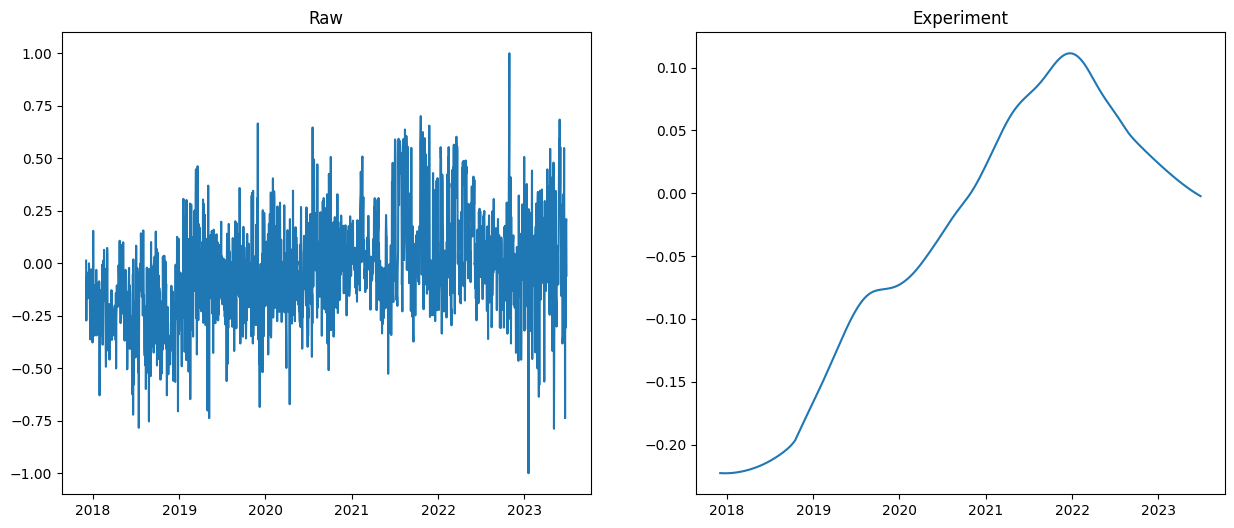

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15, 6))

ax[0].plot(dfRaw)
ax[0].set_title("Raw")

ax[1].plot(dfExperiment)
ax[1].set_title("Experiment")

plt.show()

In [ ]:
import pandas as pd
!pip install opendatasets -q
import opendatasets as od
import json
import gc

! cp ./Skripsi/Trash/kaggle.json ./
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# Download datasets using opendatasets
od.download("https://www.kaggle.com/datasets/kaushiksuresh147/bitcoin-tweets")
od.download("https://www.kaggle.com/datasets/afterrain007/reddit-bitcoin-topic-text")

mkdir: cannot create directory ‘/root/.kaggle’: File exists


100%|██████████| 695M/695M [00:15<00:00, 47.4MB/s]


100%|██████████| 49.4M/49.4M [00:00<00:00, 91.8MB/s]


In [ ]:
# reading the CSV file
df = pd.read_csv('./bitcoin-tweets/Bitcoin_tweets.csv', usecols = ['date', 'text'], dtype = {"date": str, "text" : str})
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.dropna(inplace = True)
gc.collect()
df.head()

date                                               text
0 2021-02-10 23:59:04  Blue Ridge Bank shares halted by NYSE after #b...
1 2021-02-10 23:58:48  😎 Today, that's this #Thursday, we will do a "...
2 2021-02-10 23:54:48  Guys evening, I have read this article about B...
3 2021-02-10 23:54:33  $BTC A big chance in a billion! Price: \487264...
4 2021-02-10 23:54:06  This network is secured by 9 508 nodes as of t...

In [ ]:
df2 = pd.read_csv('./reddit-bitcoin-topic-text/redditText.csv')

In [ ]:
dfAll = pd.concat([df, df2])

In [ ]:
len(dfAll)

5585180

In [ ]:
df.set_index('date', inplace = True)

In [ ]:
df.loc["2021-12"]

text
date                                                                  
2021-12-11 20:09:28  @blockchainedbb #BTC soon to be delisted along...
2021-12-11 20:09:29  Something interested I noticed is #ETH ( Pink ...
2021-12-11 20:09:35  Very interesting TA from @MMCrypto for #BTC ht...
2021-12-11 20:09:52                           #BTC is now at $48522.45
2021-12-11 20:09:54  [SCAN RESULTS - 4h]\n\nExchange: #KuCoin\n\nTo...
...                                                                ...
2021-12-30 23:59:34  @APompliano 🚨🚨🚨🚨🚨🚨🚨🚨🚨\n#Kadena is ready for a ...
2021-12-30 23:59:37  Don't complicate things.  I've been telling yo...
2021-12-30 23:59:48  @AlineEspesse @APompliano 🚨🚨🚨🚨🚨🚨🚨🚨🚨\n#Kadena i...
2021-12-30 23:59:52  @CryptoNFTs @beaniemaxi Bruuuh... I don't thin...
2021-12-30 23:59:59  @FbioAug21 @APompliano 🚨🚨🚨🚨🚨🚨🚨🚨🚨\n#Kadena is r...

[55301 rows x 1 columns]

In [ ]:
df.sort_values(by = 'date', inplace = True)

In [ ]:
df.head(1)

date                                               text
21523 2021-02-05 10:52:04  2⃣   Debunking 9 #Bitcoin Myths by @Patrick_Lo...

In [ ]:
df.tail(5)

date  \
14112462 2023-01-09 23:59:33   
14112461 2023-01-09 23:59:36   
43974752 2023-01-09 23:59:39   
14112460 2023-01-09 23:59:46   
43974751 2023-01-09 23:59:54   

                                                       text  
14112462  #BinanceCoin price update: $BNB\n\n#BNB $272.6...  
14112461  #bitcoin maxis are upset #PiNetwork is trendin...  
43974752  We're only going to be released for a few days...  
14112460  BECAUSE IT'S A LIFE\nCHANGING\nOPPORTUNITY FOR...  
43974751  $FUND HAVING A LITTLE REST BEFORE THE NEXT RIS...

In [ ]:
import pandas as pd
import numpy as np
shutil.rmtree("./Skripsi")
!git clone https://github.com/AfterRain007/Skripsi

Cloning into 'Skripsi'...
remote: Enumerating objects: 1504, done.
remote: Counting objects: 100% (411/411), done.
remote: Compressing objects: 100% (230/230), done.
remote: Total 1504 (delta 182), reused 404 (delta 179), pack-reused 1093
Receiving objects: 100% (1504/1504), 218.63 MiB | 18.69 MiB/s, done.
Resolving deltas: 100% (606/606), done.
Updating files: 100% (667/667), done.


In [ ]:
df = pd.read_csv("./Skripsi/resultTFT_MAonlyTrend.csv")

In [ ]:
# df = df[df['full_attention'] == False].copy()
df.sort_values(by = 'RMSE', inplace = True)
df.head(10)

Unnamed: 0  in_len  out_len  hidden_size  lstm_layers  \
69          69      23        1            9            1   
95          95      26        2           11            1   
96          96      26        4           11            1   
87          87      23        2           11            1   
82          82      24        7            8            1   
98          98      24       24           11            1   
74          74      13        2            9            1   
63          63       7        3            9            1   
75          75      18        4            9            1   
84          84      21        4            8            1   

    num_attention_heads   dropout  hidden_continuous_size  batch_size  \
69                    5  0.064816                       7         256   
95                    4  0.064318                       6         256   
96                    4  0.031227                       6         256   
87                    4  0.045621                       6         256   
82                    5  0.099239                       6         256   
98                    6  0.044190                       6         256   
74                    5  0.079792                       7         256   
63                    6  0.250059                       6         128   
75                    5  0.085809                       7         256   
84                    5  0.099305                       6         256   

    full_attention        lr      RMSE       MAE      MAPE  
69            True  0.004273  0.025843  0.017549  3.064315  
95           False  0.004854  0.025863  0.017389  3.033683  
96            True  0.004885  0.025931  0.017400  3.040753  
87            True  0.004684  0.025969  0.017517  3.046765  
82            True  0.004435  0.026026  0.017532  3.073742  
98            True  0.003501  0.026061  0.017630  3.087850  
74           False  0.004071  0.026121  0.017697  3.104910  
63            True  0.004509  0.026123  0.017589  3.063764  
75           False  0.004029  0.026146  0.017634  3.067436  
84            True  0.004897  0.026163  0.017475  3.044325

In [ ]:
dfResult

Unnamed: 0  in_len  out_len  hidden_size  lstm_layers  \
34          34      21       24           26            2   
89          89       8        2            8            3   
67          67      25       23           27            1   
10          10      31       25            8            1   

    num_attention_heads   dropout  hidden_continuous_size  batch_size  \
34                    3  0.267877                       7          64   
89                    2  0.258685                       8         256   
67                    8  0.049537                       9         256   
10                    8  0.223062                       8         256   

    full_attention        lr      RMSE       MAE      MAPE  type  
34           False  0.002015  0.046313  0.031195  6.725681    BP  
89            True  0.003951  0.047863  0.031632  6.981802  BPnP  
67           False  0.003397  0.026072  0.017704  3.097297    MA  
10            True  0.002241  0.026328  0.017559  3.073656  MAnP

In [ ]:
type = "TFT"

dfList2 = ['BP', 'MA']
dfList3 = ['', 'nP']

dfResult = pd.DataFrame()

for x in dfList2:
    for y in dfList3:
        temp = pd.read_csv(f"./Skripsi/result{type}_{x}{y}.csv")
        temp.sort_values(by = 'RMSE', inplace = True)
        temp['type'] = x+y
        temp.set_index('type', inplace = True)
        dfResult = pd.concat([dfResult, temp.head(1)])

dfResult

Unnamed: 0  in_len  out_len  hidden_size  lstm_layers  \
type                                                          
BP            34      21       24           26            2   
BPnP          89       8        2            8            3   
MA            67      25       23           27            1   
MAnP          10      31       25            8            1   

      num_attention_heads   dropout  hidden_continuous_size  batch_size  \
type                                                                      
BP                      3  0.267877                       7          64   
BPnP                    2  0.258685                       8         256   
MA                      8  0.049537                       9         256   
MAnP                    8  0.223062                       8         256   

      full_attention        lr      RMSE       MAE      MAPE  
type                                                          
BP             False  0.002015  0.046313  0.031195  6.725681  
BPnP            True  0.003951  0.047863  0.031632  6.981802  
MA             False  0.003397  0.026072  0.017704  3.097297  
MAnP            True  0.002241  0.026328  0.017559  3.073656

In [ ]:
timeModel = []
for index, row in dfResult.iterrows():
    df = pd.read_csv("C:/Users/Razel/Documents/GitHub/Skripsi/finalData/dataRaw.csv", parse_dates=['date'], index_col = ['date'], usecols = ['date',  'price', 'trend', 'volume', 'sen'])

    if index[:2] == "MA":
        df2 = replaceOutlierMA(df, 30)
    else:
        df2 = replaceOutlierBP(df, 'price')
        df2 = replaceOutlierBP(df2, 'volume')

    if adfuller(df2['price'])[1] > 0.05:
        df2['price'] = df2['price'].diff()

    if adfuller(df2['volume'])[1] > 0.05:
        df2['volume'] = df2['volume'].diff()

    df2 = df2.iloc[1:].copy()

    ts_ttrain, ts_ttest, cov_t = createTimeseries(df2)

    if index[2:] == "nP":
        cov_t = cov_t[['day', 'week', 'month', 'year', 'linear_increase', 'holidays']].astype(np.float32)
    else:
        cov_t = cov_t.astype(np.float32)

    # throughout training we'll monitor the validation loss for both pruning and early stopping
    my_stopper = EarlyStopping(
        monitor="val_loss",
        patience=10,
        min_delta=0.01,
        mode='min',)

    callbacks = [my_stopper]

    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": callbacks,
    }

    # reproducibility
    np.random.seed(42069)
    torch.manual_seed(42069)

    # build the TFT model
    model = TFTModel(
        input_chunk_length=row['in_len'],
        output_chunk_length=row['out_len'],
        hidden_size=int(row['hidden_size']),
        lstm_layers=row['lstm_layers'],
        num_attention_heads=row['num_attention_heads'],
        dropout=row['dropout'],
        hidden_continuous_size=row['hidden_continuous_size'],
        use_static_covariates=True,
        batch_size=int(row['batch_size']),
        optimizer_kwargs={'lr': row['lr']},
        n_epochs=500,
        nr_epochs_val_period=10,
        likelihood=None,
        loss_fn=torch.nn.MSELoss(),
        full_attention=row['full_attention'],
        torch_metrics=MeanAbsolutePercentageError(),
        random_state=42069,
        force_reset=True,
        pl_trainer_kwargs=pl_trainer_kwargs,  # Assuming pl_trainer_kwargs is defined elsewhere
        add_relative_index=False,
    )

    start = time.time()

    # train the model
    model.fit(ts_ttrain,                    # Train Price
              val_series=ts_ttest,          # Val Price
              future_covariates=cov_t,      # Val Covariate
              val_future_covariates=cov_t,  # Val Covariate
              verbose=True)

    trainingTime = time.time() - start

    start = time.time()
    pred = model.predict(len(ts_ttest))
    predictingTime = time.time() - start

    timeModel.append([index, trainingTime, predictingTime])

dfTime = pd.DataFrame(timeModel, columns = ['type', 'Training', 'Prediction'])
dfTime.set_index('type', inplace = True)
dfTime['Total Time'] = dfTime.sum(axis = 1)
dfTime

TypeError: 'int' object is not subscriptable

In [ ]:
dfList = ['TFT', 'TCN', 'GRU', 'LSTM']
dfList2 = ['', 'nP']
dfList3 = ['BP', 'MA']
df = pd.DataFrame()

for x in dfList2:
  for y in dfList:
    for z in dfList3:
      temp = pd.read_csv(f"./Skripsi/result{y}_{z}{x}.csv")
      temp.sort_values(by = 'RMSE', inplace = True)
      temp['tipe'] = y+z+x
      df = pd.concat([df, temp.head(1)])

df.reset_index(drop = True, inplace = True)
df.drop('Unnamed: 0', axis = 1, inplace = True)
# df['tipe'] = df['tipe'].replace({'TCNnP': 'TCN (Tanpa Variabel Penjelas)', 'TFTnP': 'TFT (Tanpa Variabel Penjelas)',
#                                  'GRUnP': 'GRU (Tanpa Variabel Penjelas)', 'LSTMnP': 'LSTM (Tanpa Variabel Penjelas)'})

# df = df[['tipe', 'RMSE', 'MAE', 'MAPE']].copy()
# df.sort_values(by = "RMSE", inplace = True)

df.to_excel("resultMovingAverage.xlsx", index = False)
df

in_len  out_len  hidden_size  lstm_layers  num_attention_heads   dropout  \
0     21.0     24.0         26.0          2.0                  3.0  0.267877   
1     25.0     23.0         27.0          1.0                  8.0  0.049537   
2      2.0      1.0          NaN          NaN                  NaN  0.230073   
3      7.0      2.0          NaN          NaN                  NaN  0.023468   
4      NaN      NaN          NaN          NaN                  NaN  0.199240   
5      NaN      NaN          NaN          NaN                  NaN  0.080664   
6      NaN      NaN          NaN          NaN                  NaN  0.199006   
7      NaN      NaN          NaN          NaN                  NaN  0.054703   
8      8.0      2.0          8.0          3.0                  2.0  0.258685   
9     31.0     25.0          8.0          1.0                  8.0  0.223062   
10    16.0      3.0          NaN          NaN                  NaN  0.291110   
11    24.0     18.0          NaN          NaN                  NaN  0.281930   
12     NaN      NaN          NaN          NaN                  NaN  0.135224   
13     NaN      NaN          NaN          NaN                  NaN  0.067270   
14     NaN      NaN          NaN          NaN                  NaN  0.096764   
15     NaN      NaN          NaN          NaN                  NaN  0.064655   

    hidden_continuous_size  batch_size full_attention        lr  ...  type  \
0                      7.0          64          False  0.002015  ...   NaN   
1                      9.0         256          False  0.003397  ...  30.0   
2                      NaN         256            NaN  0.002877  ...   NaN   
3                      NaN         128            NaN  0.003341  ...   NaN   
4                      NaN         256            NaN  0.003652  ...   NaN   
5                      NaN         256            NaN  0.002912  ...   NaN   
6                      NaN         256            NaN  0.001774  ...   NaN   
7                      NaN         256            NaN  0.002206  ...   NaN   
8                      8.0         256           True  0.003951  ...   NaN   
9                      8.0         256           True  0.002241  ...   NaN   
10                     NaN         128            NaN  0.002999  ...   NaN   
11                     NaN          64            NaN  0.004579  ...   NaN   
12                     NaN         128            NaN  0.001833  ...   NaN   
13                     NaN         256            NaN  0.003925  ...   NaN   
14                     NaN         256            NaN  0.001901  ...   NaN   
15                     NaN          64            NaN  0.002037  ...   NaN   

    kernel_size  num_filters weight_norm  dilation_base  num_layers  \
0           NaN          NaN         NaN            NaN         NaN   
1           NaN          NaN         NaN            NaN         NaN   
2           1.0          6.0        True            4.0         5.0   
3           1.0          2.0       False            3.0         2.0   
4           NaN          NaN         NaN            NaN         NaN   
5           NaN          NaN         NaN            NaN         NaN   
6           NaN          NaN         NaN            NaN         NaN   
7           NaN          NaN         NaN            NaN         NaN   
8           NaN          NaN         NaN            NaN         NaN   
9           NaN          NaN         NaN            NaN         NaN   
10          2.0          6.0       False            4.0         5.0   
11         15.0          2.0        True            4.0         1.0   
12          NaN          NaN         NaN            NaN         NaN   
13          NaN          NaN         NaN            NaN         NaN   
14          NaN          NaN         NaN            NaN         NaN   
15          NaN          NaN         NaN            NaN         NaN   

    input_chunk_length training_length  hidden_dim  n_rnn_layers  
0                  NaN             NaN   

In [ ]:
dfList = ['TFT', 'TCN', 'GRU', 'LSTM']
dfList2 = ['', 'nP']
df = pd.DataFrame()

for x in dfList2:
  for y in dfList:
    temp = pd.read_csv(f"./Skripsi/result{y}_BP{x}.csv")
    temp.sort_values(by = 'RMSE', inplace = True)
    temp['tipe'] = y+x
    df = pd.concat([df, temp.head(1)])

df.reset_index(drop = True, inplace = True)
df['tipe'] = df['tipe'].replace({'TCNnP': 'TCN (Tanpa Variabel Penjelas)', 'TFTnP': 'TFT (Tanpa Variabel Penjelas)',
                                 'GRUnP': 'GRU (Tanpa Variabel Penjelas)', 'LSTMnP': 'LSTM (Tanpa Variabel Penjelas)'})

df = df[['tipe', 'RMSE', 'MAE', 'MAPE']].copy()
# df.sort_values(by = "RMSE", inplace = True)

df.to_excel("resultBoxPlot.xlsx", index = False)
df

tipe      RMSE       MAE      MAPE
0                             TFT  0.046313  0.031195  6.725681
1                             TCN  0.047726  0.032158  7.008401
2                             GRU  0.047539  0.031575  6.944174
3                            LSTM  0.047694  0.031432  6.930556
4   TFT (Tanpa Variabel Penjelas)  0.047863  0.031632  6.981802
5   TCN (Tanpa Variabel Penjelas)  0.047953  0.031774  7.004163
6   GRU (Tanpa Variabel Penjelas)  0.047862  0.031803  7.024983
7  LSTM (Tanpa Variabel Penjelas)  0.047921  0.031688  7.006321

In [ ]:
df = pd.read_csv("./Skripsi/dataRaw.csv", parse_dates=['date'], index_col='date')

In [ ]:
df['price'] = df['price'].diff()
df['volume'] = df['volume'].diff()
df = df.iloc[1:].copy()

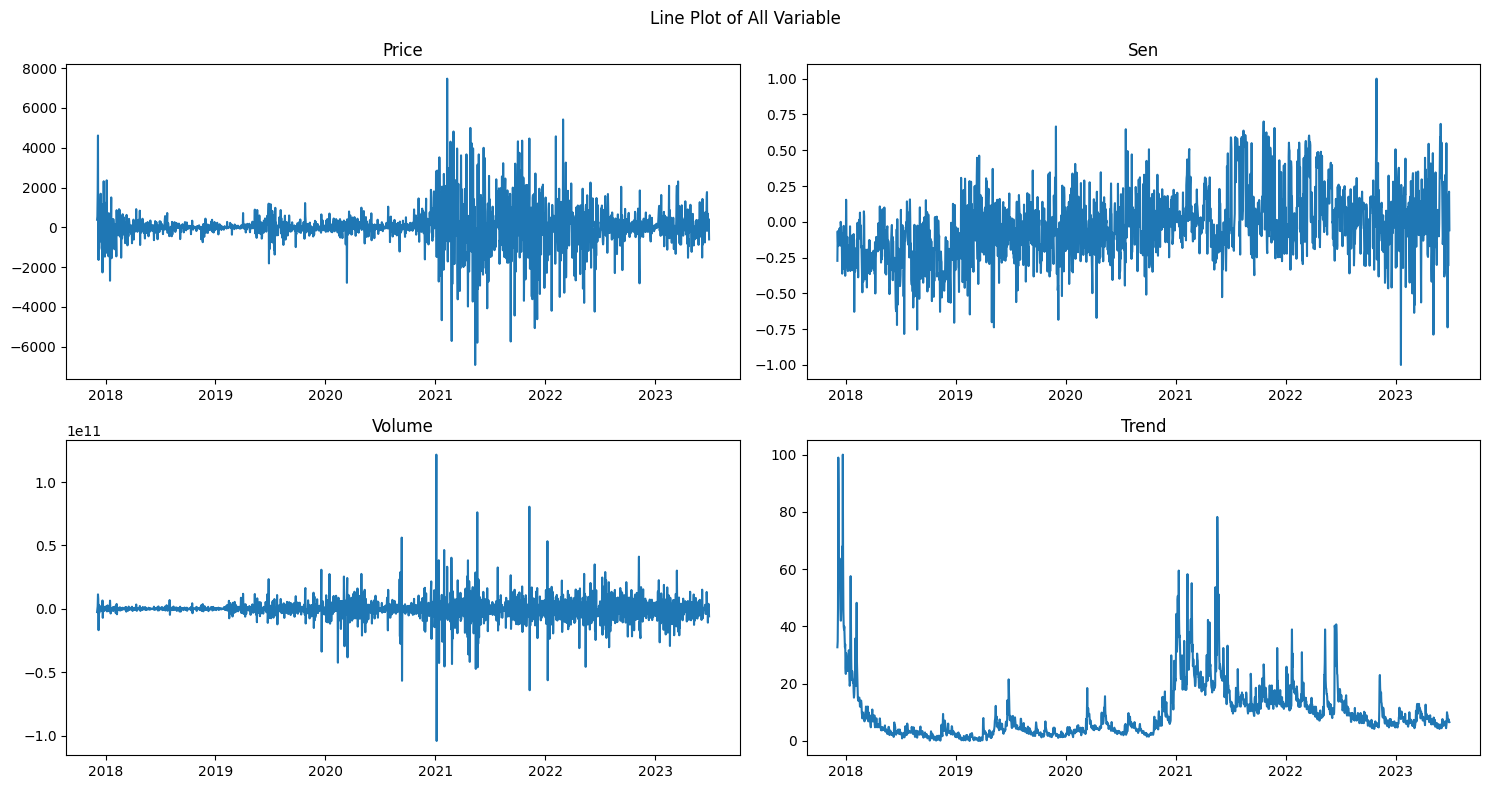

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15, 8))

for i, x in enumerate(df.columns):
  ax[i%2, (i // 2) % 2].plot(df.index, df[x])
  ax[i%2, (i // 2) % 2].set_title(x.capitalize())

fig.suptitle('Line Plot of All Variable')

plt.tight_layout()
plt.show()

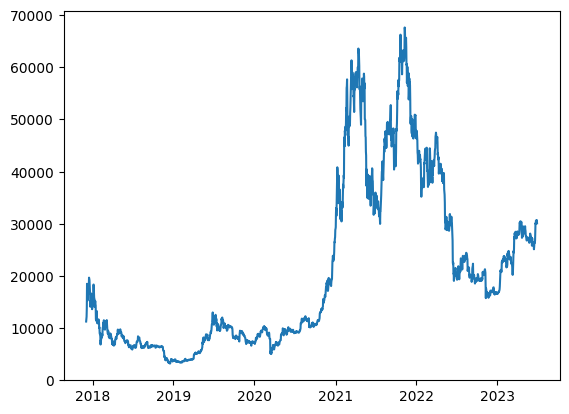

In [ ]:
plt.plot(df['price'])

   label  lower_whisker  lower_quartile        median  upper_quartile  \
0  price     3216.62715     8104.728892  13106.046019    30308.484697   

   upper_whisker  
0   63576.676041  


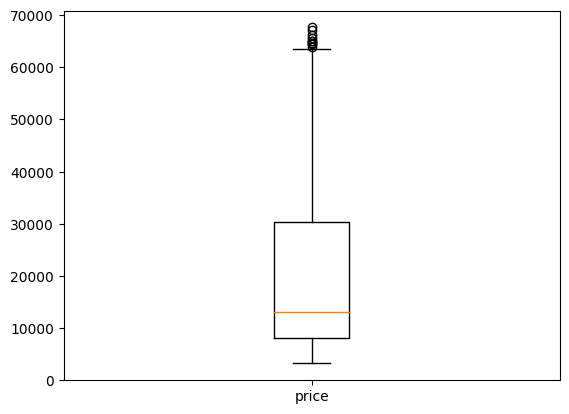

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def get_box_plot_data(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)

labels = ['price']
bp = plt.boxplot(df[['price']], labels=labels)
print(get_box_plot_data(labels, bp))
plt.show()

10


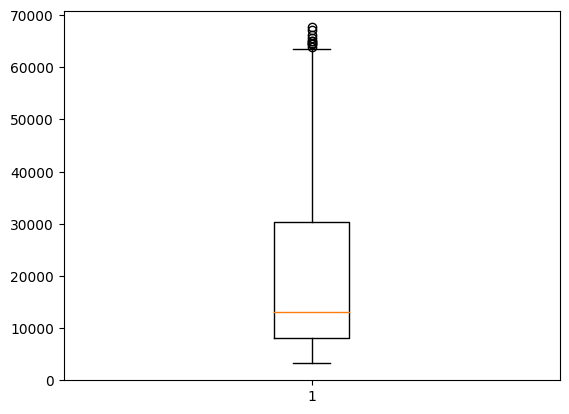

In [ ]:
# Create a box plot and capture the output to get outlier values
boxplot_output = plt.boxplot(df['price'], showfliers=True)

# Extract outlier values
outlier_values = [flier.get_ydata() for flier in boxplot_output['fliers']]

print(len(outlier_values[0]))

50


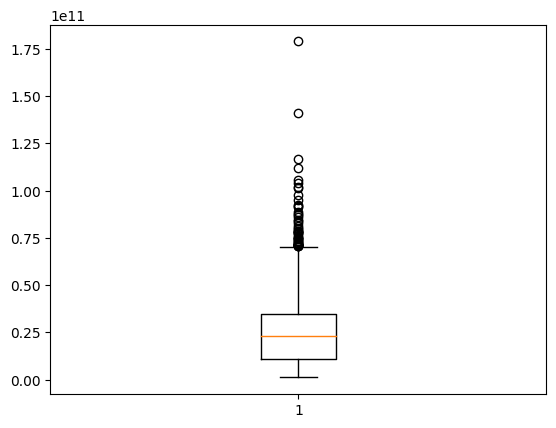

In [ ]:
# Create a box plot and capture the output to get outlier values
boxplot_output = plt.boxplot(df['volume'], showfliers=True)

# Extract outlier values
outlier_values = [flier.get_ydata() for flier in boxplot_output['fliers']]

print(len(outlier_values[0]))